# Merge Conflict Prediction in Software Projects
This notebook implements a machine learning solution to predict merge conflicts in software projects using scikit-learn. Following the end-to-end machine learning project methodology, we'll build classifiers that can identify potential conflicts before they occur, potentially saving developer time and reducing integration challenges.


# Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Setting Seaborn style for better visualizations
sns.set(style="whitegrid")

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "merge_conflict_classifier"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data Loading and Visual Exploration

We begin by loading the MergeConflictsDataset.csv and exploring its basic properties. The dataset contains information about:
- Pull request status
- Number of added/deleted lines
- Number of developers on each branch
- Duration of parallel development
- Number of changed files
- Commit metrics (count, density)
- Commit message characteristics

We'll analyze these features to identify patterns that predict merge conflicts.


In [4]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv('MergeConflictsDataset.csv', sep=';')

Loading dataset...


In [70]:
# Check dataset shape
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

Dataset shape: (26973, 37)

Sample data:
                                     commit  \
0  efc0bcd1d6199448c323549fdc45310750b48c85   
1  287b9b838b6b6b212ef538aa537aef76110ee111   
2  e7478680c0db825239ea9628967728c8577bb5c2   
3  0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff   
4  419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f   

                                    parent1  \
0  fb9f2a65cabba5a924b89a45793914066471b2ab   
1  72fd7d81c9c7e28af8740f5a1b210a803290383d   
2  36977963caa2896ad9a4a92b2bdcd85189beccb1   
3  419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f   
4  7899f565d3461ed287e61662c8d399aafcac9e42   

                                    parent2  \
0  5ee7c7c750e9ecffaea12f97d5b05b2445e7c007   
1  fb9f2a65cabba5a924b89a45793914066471b2ab   
2  bc230857adc3a9763bc7d89793d826463c857c00   
3  877c43f8242b88447d0234400c6e9b5c7586b558   
4  5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6   

                                   ancestor  is pr  added lines  \
0  fb9f2a65cabba5a924b89a45793914066471b2ab

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26972 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

In [73]:
# Check target variable distribution
print("\nTarget variable distribution:")
conflict_counts = df['conflict'].value_counts()
conflict_percentage = df['conflict'].mean() * 100
print(conflict_counts)
print(f"Percentage of conflicts: {conflict_percentage:.2f}%")


Target variable distribution:
conflict
0    25505
1     1468
Name: count, dtype: int64
Percentage of conflicts: 5.44%


Saving figure class_distribution.png


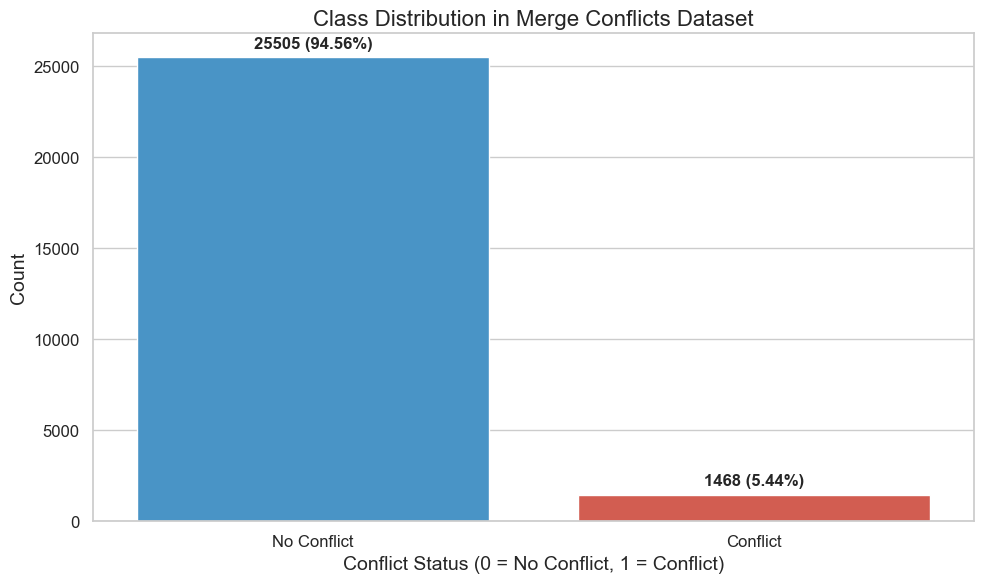

In [74]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='conflict', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Class Distribution in Merge Conflicts Dataset', fontsize=16)
plt.xlabel('Conflict Status (0 = No Conflict, 1 = Conflict)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['No Conflict', 'Conflict'])

# Annotate the bars with counts and percentages
for i, count in enumerate(conflict_counts):
    plt.text(i, count + 500, f'{count} ({count/len(df)*100:.2f}%)', 
             ha='center', fontsize=12, fontweight='bold')
save_fig('class_distribution')
plt.show()

In [5]:
# Identify non-feature columns (commit hashes and identifiers)
non_feature_cols = ['commit', 'parent1', 'parent2', 'ancestor']
feature_cols = [col for col in df.columns if col not in non_feature_cols and col != 'conflict']

In [6]:
# Prepare features and target
X = df[feature_cols]
y = df['conflict']

In [92]:
print(f"\nNumber of features: {len(feature_cols)}")
print("\nFeature columns:")
for i, col in enumerate(feature_cols):
    print(f"{i+1}. {col}")


Number of features: 32

Feature columns:
1. is pr
2. added lines
3. deleted lines
4. devs parent1
5. devs parent2
6. time
7. nr files
8. added files
9. deleted files
10. renamed files
11. copied files
12. modified files
13. nr commits1
14. nr commits2
15. density1
16. density2
17. fix
18. bug
19. feature
20. improve
21. document
22. refactor
23. update
24. add
25. remove
26. use
27. delete
28. change
29. messages_min
30. messages_max
31. messages_mean
32. messages_median


In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")


Missing values per column:
ancestor    1
dtype: int64


In [7]:
df.dropna(inplace=True)  # Drop rows with missing values

missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")


Missing values per column:
No missing values


**Initial observations:**
- The dataset contains 26,973 records with 37 columns
- There is significant class imbalance with only 5.44% of cases representing conflicts
- No missing values are detected, which simplifies the preprocessing

The severe class imbalance (94.56% non-conflicts vs. 5.44% conflicts) will be a key challenge for the modeling approach. This means accuracy would be a misleading metric—a model always predicting "no conflict" would achieve 94.56% accuracy but provide no value.

## Data Analysis 

### Statistical Summary

The descriptive statistics reveal wide ranges for many features:
- Some merges involve hundreds of developers
- Line additions/deletions can exceed 1 million
- Time duration ranges from 0 to over 21,000 hours
- The number of files changed ranges from 0 to over 1,100

These extreme ranges suggest we'll need scaling to handle these variations. Additionally, some very large values may represent outliers, but they could also represent legitimate complex merges that are more likely to cause conflicts.

In [108]:
# Statistical summary of numerical features
print("\nStatistical summary of numerical features:")
df.describe()


Statistical summary of numerical features:


,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
count,26973.000000,2.697300e+04,2.697300e+04,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,...,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000
mean,0.777741,4.255746e+02,2.504278e+02,4.656175,1.911801,240.714159,0.752048,2.431061,1.396545,0.970229,...,4.316205,0.955437,1.338857,0.096281,1.007860,51.391280,104.662551,69.455646,68.021095,0.054425
std,0.415772,8.887706e+03,1.027916e+04,12.230444,6.534316,908.382038,10.620490,67.840678,90.614277,64.245155,...,12.924317,3.203307,4.269666,0.541916,6.033535,34.560112,89.471017,40.057823,39.385369,0.226858
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000e+00,1.000000e+00,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,47.000000,41.000000,40.000000,0.000000
50%,1.000000,1.100000e+01,2.000000e+00,1.000000,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,46.000000,88.000000,66.391304,65.000000,0.000000
75%,1.000000,7.500000e+01,1.500000e+01,3.000000,1.000000,139.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,67.000000,131.000000,91.714286,90.000000,0.000000
max,1.000000,1.140945e+06,1.140456e+06,158.000000,182.000000,21513.000000,1152.000000,10404.000000,10396.000000,10398.000000,...,176.000000,48.000000,78.000000,16.000000,312.000000,1326.000000,1326.000000,1326.000000,1326.000000,1.000000


### Feature Distributions by Conflict Status

Saving figure feature_boxplots


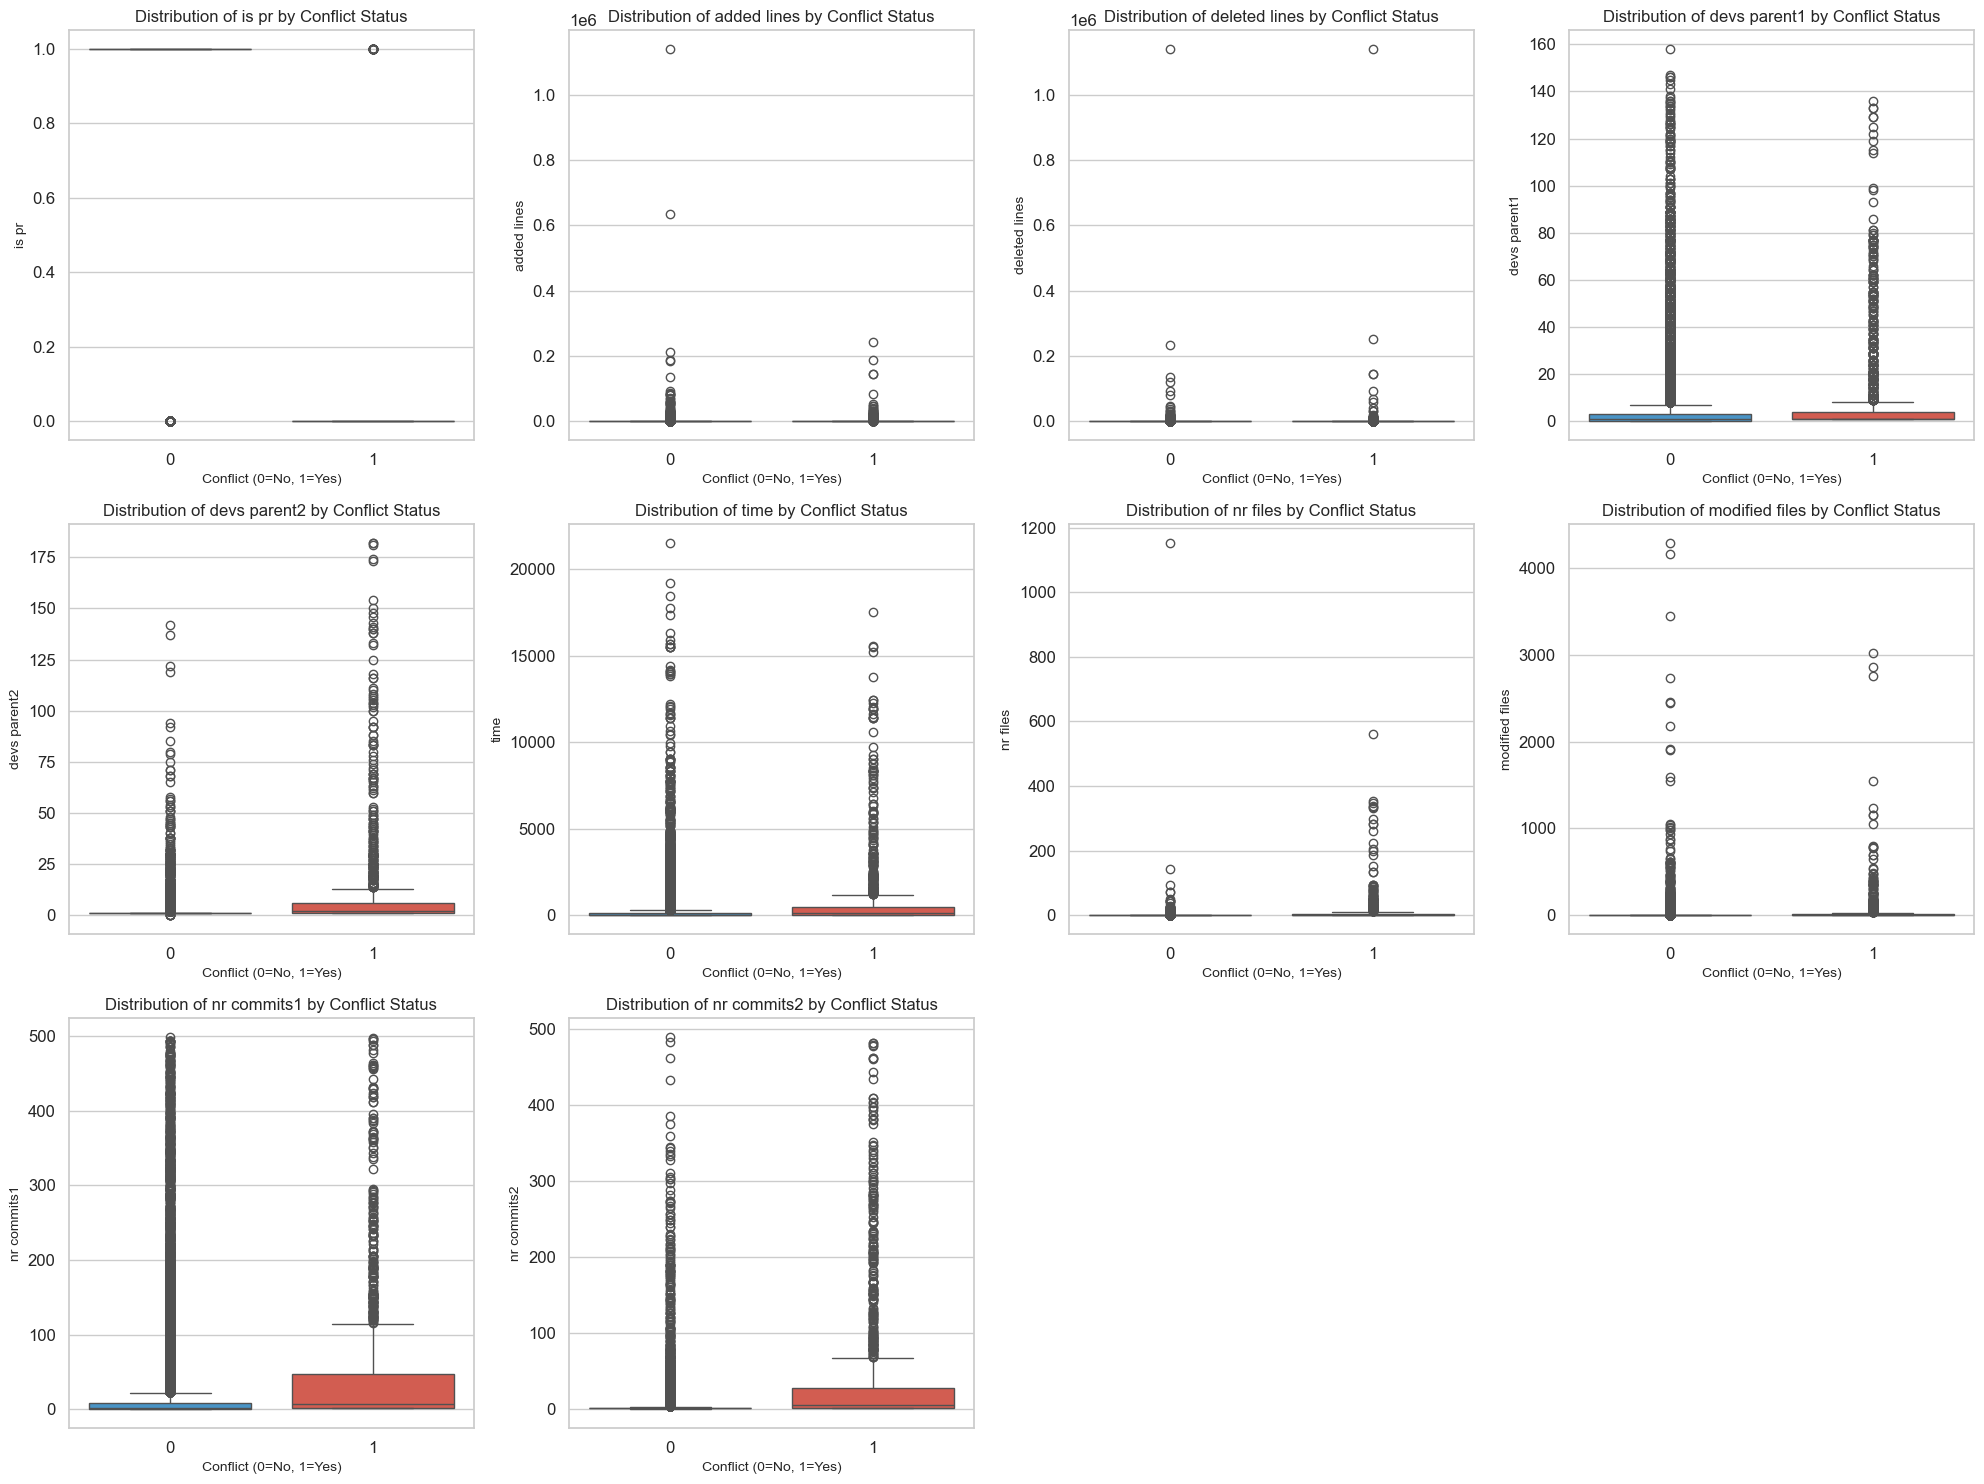

In [116]:
# Check distributions of key features by conflict status
plt.figure(figsize=(20, 15))
features_to_plot = ['is pr', 'added lines', 'deleted lines', 'devs parent1', 
                   'devs parent2', 'time', 'nr files', 'modified files', 
                   'nr commits1', 'nr commits2']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='conflict', y=feature, data=df, palette=['#3498db', '#e74c3c'])
    plt.title(f'Distribution of {feature} by Conflict Status', fontsize=12)
    plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=10)
    plt.ylabel(feature, fontsize=10)

    # # Add mean values with percentages on the plot
    # for j, conflict in enumerate([0, 1]):
    #     mean_val = df[df['conflict'] == conflict][feature].mean()
    #     plt.text(j, mean_val, f'Mean: {mean_val:.1f}', 
    #              ha='center', va='bottom', fontsize=9, fontweight='bold')
    
plt.tight_layout()
save_fig('feature_boxplots')
plt.show()

In [93]:
# Check distribution statistics for key features
print("\nDistribution statistics for key features by conflict status:")
for feature in features_to_plot:
    conflict_stats = df[df['conflict'] == 1][feature].describe()[['mean', '50%', 'max']]
    no_conflict_stats = df[df['conflict'] == 0][feature].describe()[['mean', '50%', 'max']]
    
    print(f"\n{feature}:")
    print(f"  Conflict cases - Mean: {conflict_stats['mean']:.2f}, Median: {conflict_stats['50%']:.2f}, Max: {conflict_stats['max']:.2f}")
    print(f"  No conflict cases - Mean: {no_conflict_stats['mean']:.2f}, Median: {no_conflict_stats['50%']:.2f}, Max: {no_conflict_stats['max']:.2f}")
    print(f"  Ratio (conflict/no-conflict) - Mean: {conflict_stats['mean']/no_conflict_stats['mean']:.2f}, Median: {conflict_stats['50%']/no_conflict_stats['50%']:.2f}")


Distribution statistics for key features by conflict status:

is pr:
  Conflict cases - Mean: 0.02, Median: 0.00, Max: 1.00
  No conflict cases - Mean: 0.82, Median: 1.00, Max: 1.00
  Ratio (conflict/no-conflict) - Mean: 0.02, Median: 0.00

added lines:
  Conflict cases - Mean: 1913.09, Median: 106.50, Max: 243899.00
  No conflict cases - Mean: 339.96, Median: 10.00, Max: 1140945.00
  Ratio (conflict/no-conflict) - Mean: 5.63, Median: 10.65

deleted lines:
  Conflict cases - Mean: 1827.88, Median: 20.00, Max: 1140456.00
  No conflict cases - Mean: 159.63, Median: 2.00, Max: 1139738.00
  Ratio (conflict/no-conflict) - Mean: 11.45, Median: 10.00

devs parent1:
  Conflict cases - Mean: 8.42, Median: 1.00, Max: 136.00
  No conflict cases - Mean: 4.44, Median: 1.00, Max: 158.00
  Ratio (conflict/no-conflict) - Mean: 1.90, Median: 1.00

devs parent2:
  Conflict cases - Mean: 9.39, Median: 2.00, Max: 182.00
  No conflict cases - Mean: 1.48, Median: 1.00, Max: 142.00
  Ratio (conflict/no-conf

In [91]:
# Check for extreme values in key features
print("\nExtreme values in key features:")
for feature in features_to_plot:
    percentiles = [0, 50, 90, 95, 99, 100]
    p_values = np.percentile(X[feature], percentiles)
    print(f"{feature} percentiles {percentiles}: {p_values}")


Extreme values in key features:
is pr percentiles [0, 50, 90, 95, 99, 100]: [0. 1. 1. 1. 1. 1.]
added lines percentiles [0, 50, 90, 95, 99, 100]: [0.000000e+00 1.100000e+01 3.160000e+02 7.760000e+02 5.377280e+03
 1.140945e+06]
deleted lines percentiles [0, 50, 90, 95, 99, 100]: [0.000000e+00 2.000000e+00 9.200000e+01 2.630000e+02 2.247640e+03
 1.140456e+06]
devs parent1 percentiles [0, 50, 90, 95, 99, 100]: [  0.   1.  10.  23.  68. 158.]
devs parent2 percentiles [0, 50, 90, 95, 99, 100]: [  0.     1.     2.     3.    21.28 182.  ]
time percentiles [0, 50, 90, 95, 99, 100]: [    0.     36.    452.    909.4  3982.  21513. ]
nr files percentiles [0, 50, 90, 95, 99, 100]: [0.000e+00 0.000e+00 1.000e+00 2.000e+00 9.000e+00 1.152e+03]
modified files percentiles [0, 50, 90, 95, 99, 100]: [0.000e+00 1.000e+00 8.000e+00 1.700e+01 1.100e+02 4.289e+03]
nr commits1 percentiles [0, 50, 90, 95, 99, 100]: [  0.    2.   44.  102.4 333.  499. ]
nr commits2 percentiles [0, 50, 90, 95, 99, 100]: [  0. 

**Key observations:**
- **Number of files (`nr files`)**: Dramatically higher in conflict cases 
- **Modified files**: Considerably more in conflict cases 
- **Developer count**: More developers are involved in conflict cases
- **Commit counts**: Conflict cases show higher commit activity
- **Time**: Longer parallel development correlates with conflicts

These differences provide strong signals for our predictive models. Merges with more files changed, more developers involved, and longer development times are much more likely to result in conflicts.

The extreme values (outliers) appear to be meaningful rather than errors, as they often correspond to conflict cases. We'll preserve these values rather than removing them.

### Correlation Analysis

In [94]:
# Correlation with target
correlation_with_target = X.corrwith(y).sort_values(ascending=False)
print("\nTop 10 features by correlation with target (conflict):")
print(correlation_with_target.head(10))

print("\nBottom 5 features by correlation with target (conflict):")
print(correlation_with_target.tail(5))


Top 10 features by correlation with target (conflict):
nr commits2     0.303397
devs parent2    0.274583
add             0.235729
density2        0.219509
remove          0.202772
nr files        0.172194
fix             0.164832
update          0.158182
messages_max    0.153547
refactor        0.144355
dtype: float64

Bottom 5 features by correlation with target (conflict):
added files        0.019285
messages_median    0.018941
messages_min      -0.082620
is pr             -0.436992
copied files            NaN
dtype: float64


Saving figure feature_target_correlation


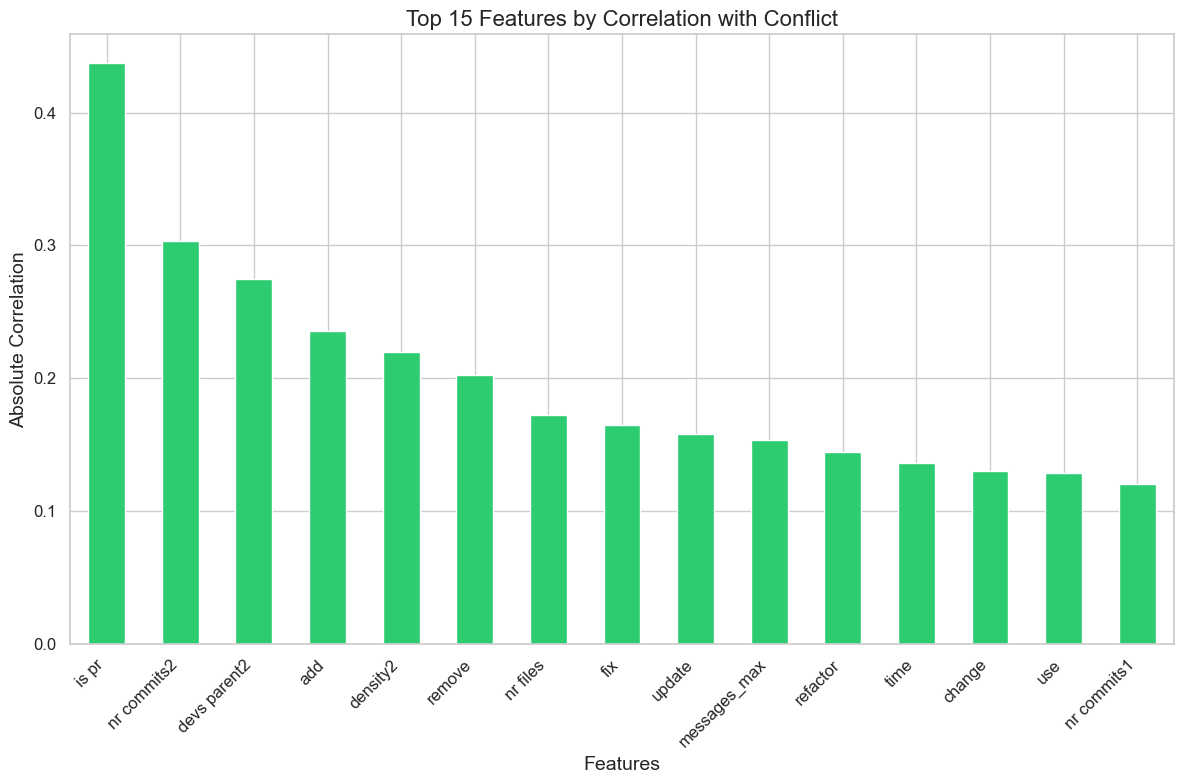

In [121]:
# Visualize top correlated features with target
plt.figure(figsize=(12, 8))
correlation_with_target.abs().sort_values(ascending=False).head(15).plot(kind='bar', color='#2ecc71')
plt.title('Top 15 Features by Correlation with Conflict', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Absolute Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('feature_target_correlation')
plt.show()


Saving figure correlation_heatmap


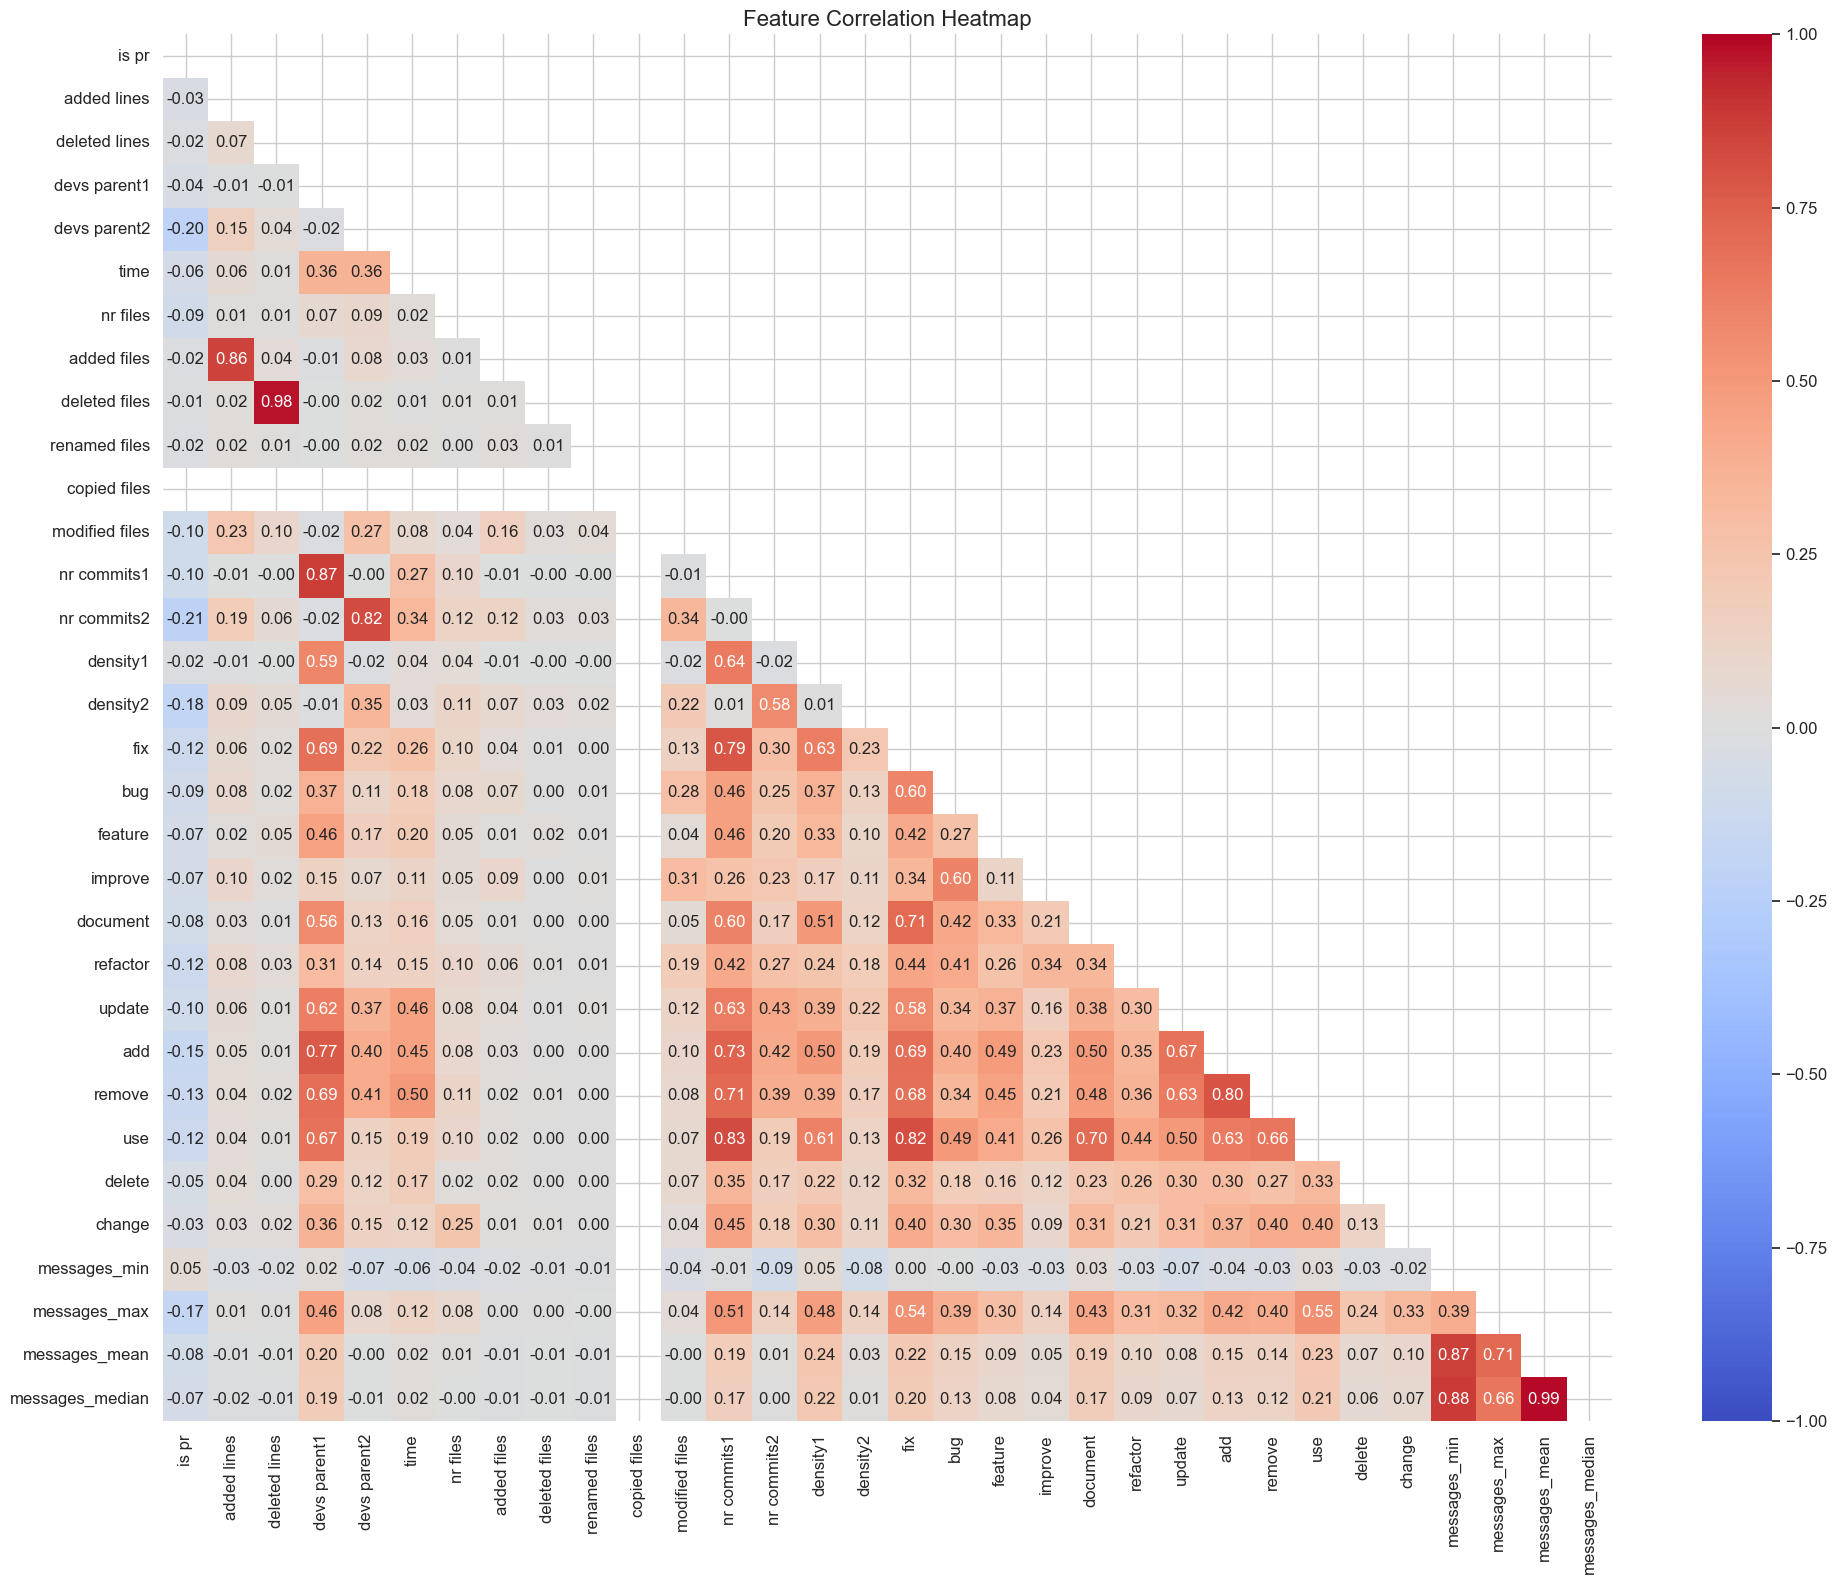

In [ ]:
# Correlation heatmap between features
plt.figure(figsize=(20, 16))
# # Select key features for a more readable heatmap
# key_features = ['is pr', 'nr files', 'modified files', 'deleted files', 
#                 'renamed files', 'devs parent1', 'devs parent2', 
#                 'nr commits1', 'nr commits2', 'time', 'conflict']
#correlation = df[key_features].corr()
correlation = X.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
save_fig('correlation_heatmap')
plt.show()

### PR Status Analysis


Saving figure pr_vs_conflict


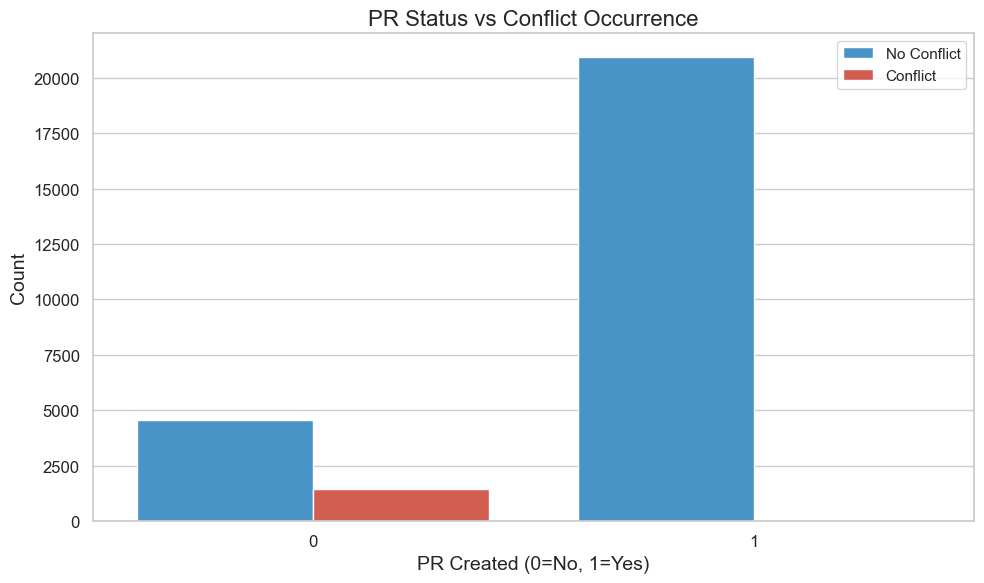

In [127]:
# Check relationship between PR status and conflicts
plt.figure(figsize=(10, 6))
sns.countplot(x='is pr', hue='conflict', data=df, palette=['#3498db', '#e74c3c'])
plt.title('PR Status vs Conflict Occurrence', fontsize=16)
plt.xlabel('PR Created (0=No, 1=Yes)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['No Conflict', 'Conflict'])
plt.tight_layout()
save_fig('pr_vs_conflict')
plt.show()

In [128]:
# Calculate PR impact statistics
pr_conflict_rate = df[df['is pr'] == 1]['conflict'].mean() * 100
no_pr_conflict_rate = df[df['is pr'] == 0]['conflict'].mean() * 100
print(f"\nConflict rate when PR is used: {pr_conflict_rate:.2f}%")
print(f"Conflict rate when PR is NOT used: {no_pr_conflict_rate:.2f}%")
print(f"PR reduces conflict probability by {(no_pr_conflict_rate - pr_conflict_rate)/no_pr_conflict_rate*100:.2f}%")


Conflict rate when PR is used: 0.14%
Conflict rate when PR is NOT used: 23.99%
PR reduces conflict probability by 99.40%


**PR status analysis:**
- Using Pull Requests (`is pr`=1) dramatically reduces conflict risk
- Most conflicts occur when PR workflows are not used
- This validates the industry practice of using PRs for code review before merging

### Commit Message Analysis

Saving figure message_length_boxplots


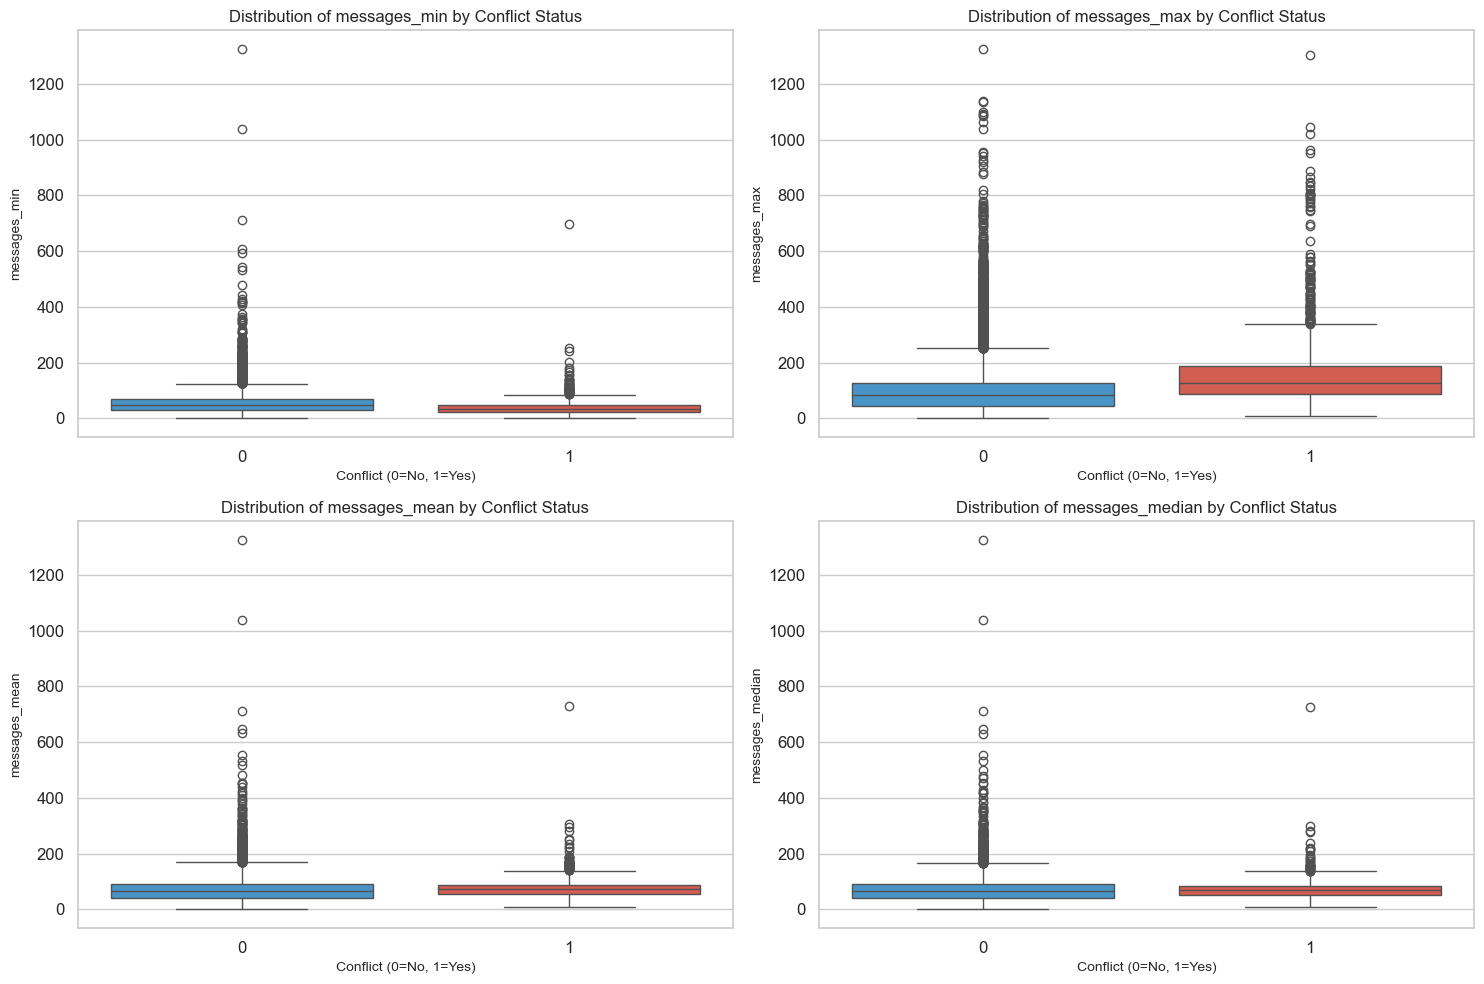

In [ ]:
# Analyze commit message features
message_features = ['fix', 'bug', 'feature', 'improve', 'document', 'refactor', 
                    'update', 'add', 'remove', 'use', 'delete', 'change',
                    'messages_min', 'messages_max', 'messages_mean', 'messages_median']

# Boxplots for commit message length features
plt.figure(figsize=(15, 10))
message_length_features = ['messages_min', 'messages_max', 'messages_mean', 'messages_median']

for i, feature in enumerate(message_length_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='conflict', y=feature, data=df, palette=['#3498db', '#e74c3c'])
    plt.title(f'Distribution of {feature} by Conflict Status', fontsize=12)
    plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=10)
    plt.ylabel(feature, fontsize=10)
    
plt.tight_layout()
save_fig('message_length_boxplots')
plt.show()

Saving figure keyword_frequencies


<Figure size 1500x800 with 0 Axes>

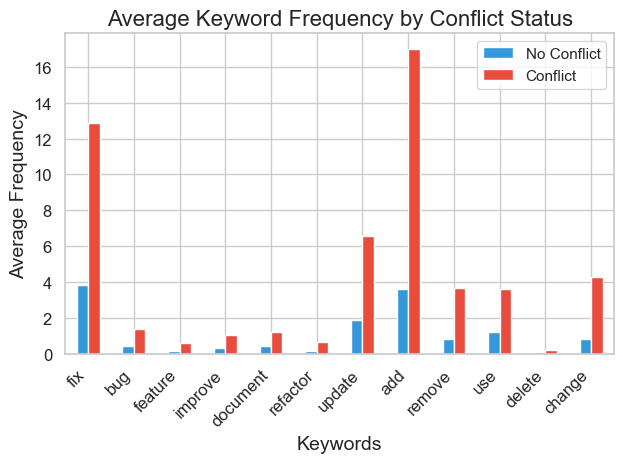

In [130]:
#  Visualize keyword frequencies
plt.figure(figsize=(15, 8))
keyword_features = ['fix', 'bug', 'feature', 'improve', 'document', 'refactor', 
                   'update', 'add', 'remove', 'use', 'delete', 'change']

keyword_means = df.groupby('conflict')[keyword_features].mean()
keyword_means.T.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Average Keyword Frequency by Conflict Status', fontsize=16)
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Average Frequency', fontsize=14)
plt.legend(['No Conflict', 'Conflict'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('keyword_frequencies')
plt.show()

Commit messages may provide insight into the nature of changes and conflict risk:
- Average message length (`messages_mean`) tends to be slightly higher in non-conflict cases
- This supports the hypothesis that better-documented commits might correlate with fewer conflicts
- Keywords like "fix", "add", and "update" appear slightly more frequently in conflict cases
- "fix" and "add" keywords show the largest differences


### Key Feature Interactions

Saving figure feature_scatter_plots


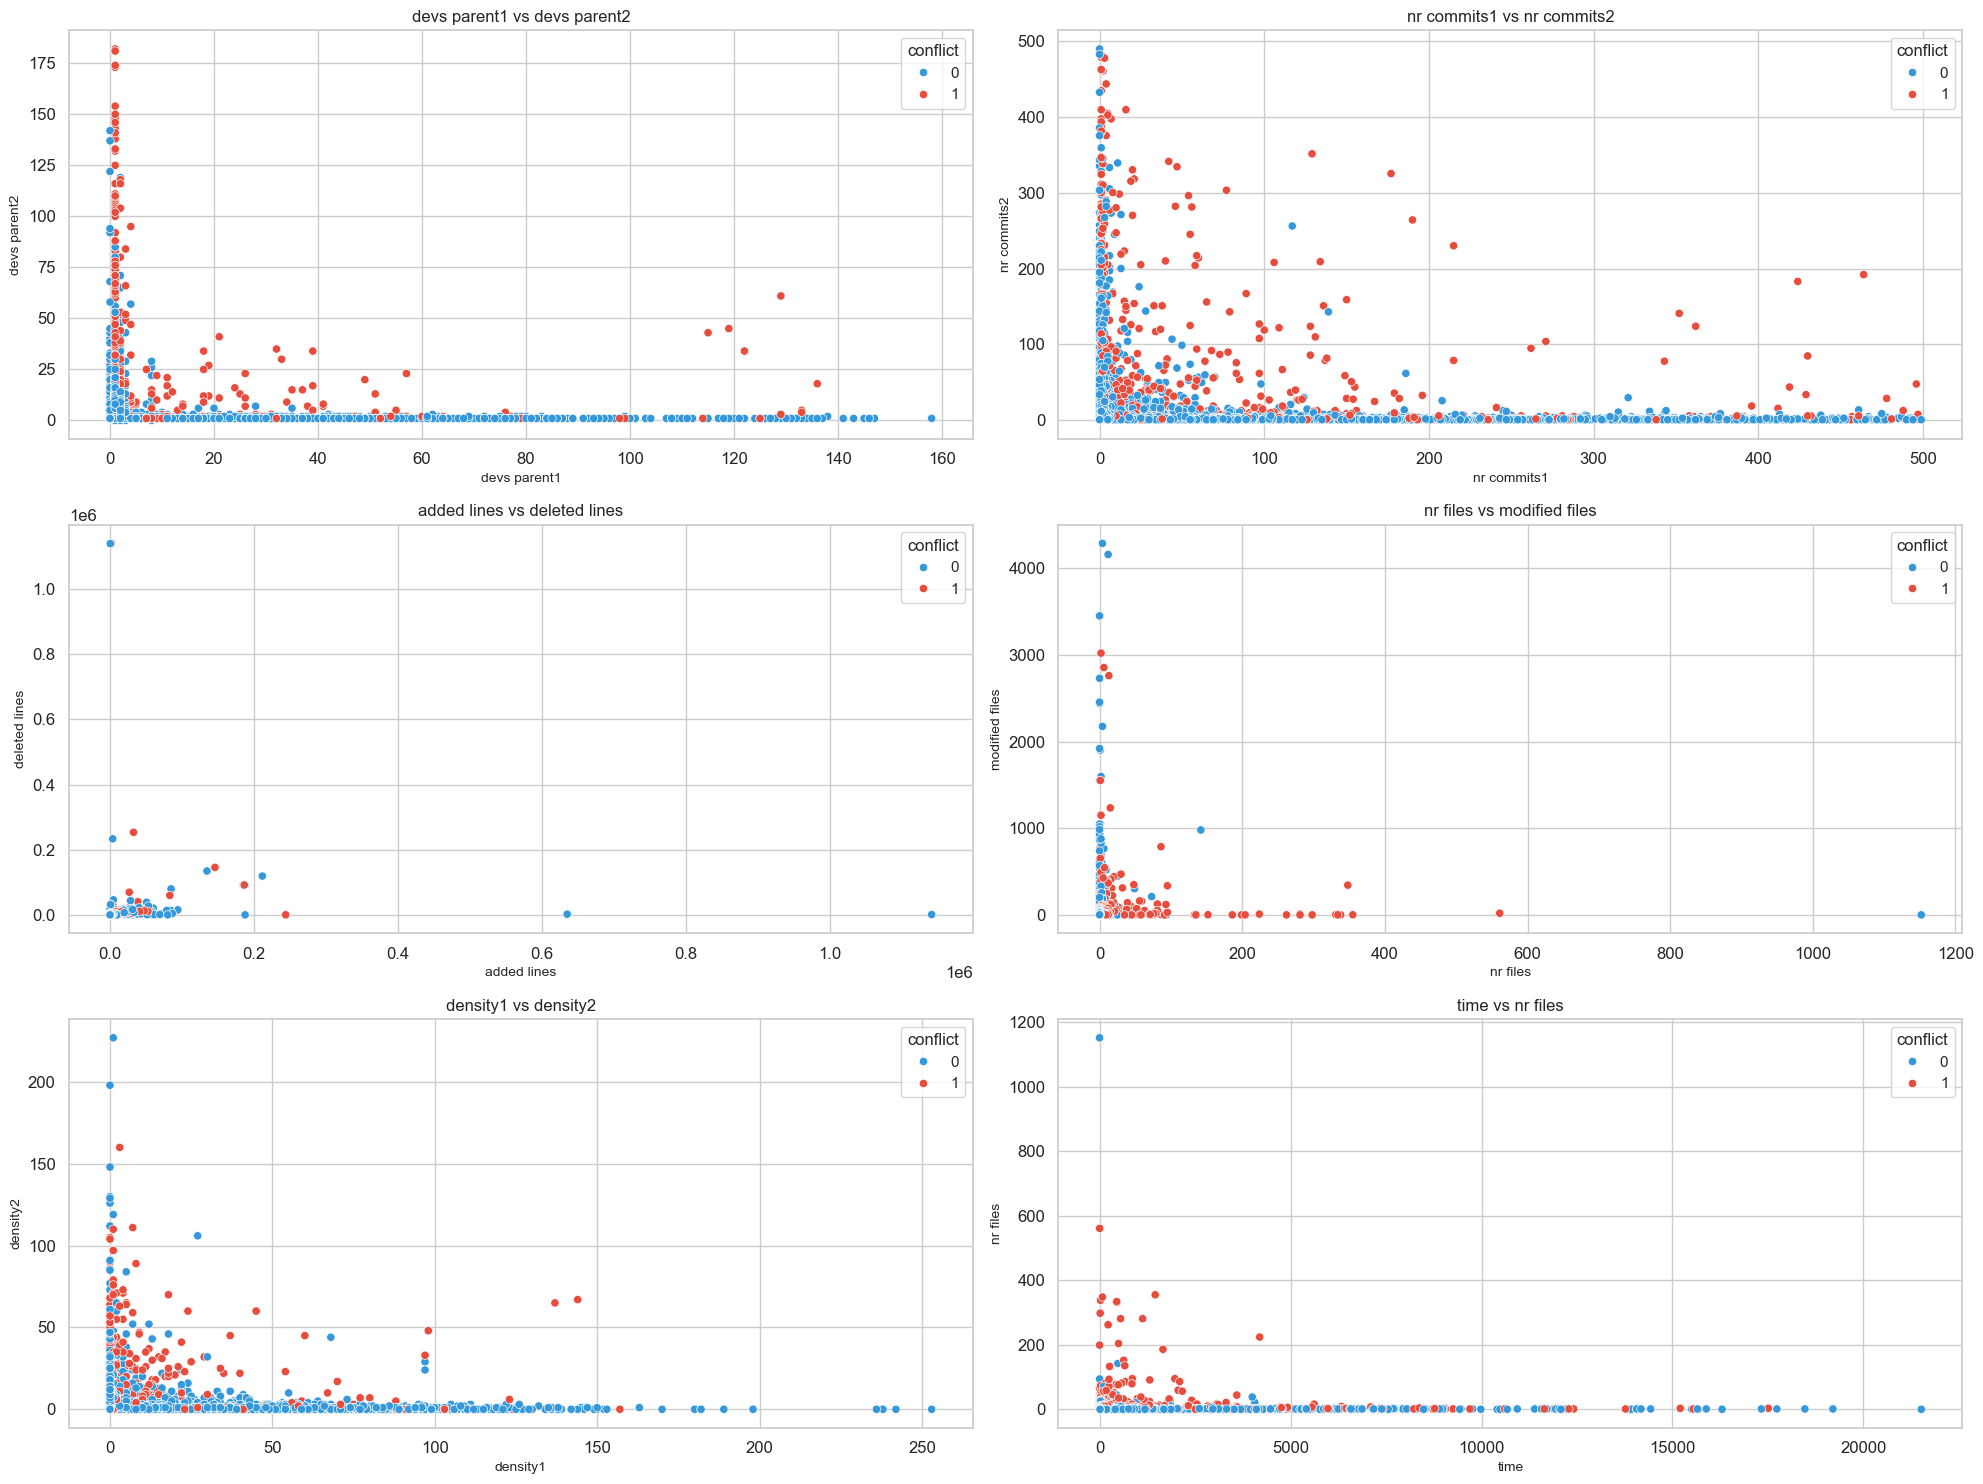

In [ ]:
# Create scatter plots for related feature pairs
plt.figure(figsize=(20, 15))
scatter_pairs = [
    ('devs parent1', 'devs parent2'),
    ('nr commits1', 'nr commits2'),
    ('added lines', 'deleted lines'),
    ('nr files', 'modified files'),
    ('density1', 'density2'),
    ('time', 'nr files')
]

for i, (x_feature, y_feature) in enumerate(scatter_pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=x_feature, y=y_feature, hue='conflict', data=df, palette=['#3498db', '#e74c3c'])
    plt.title(f'{x_feature} vs {y_feature}', fontsize=12)
    plt.xlabel(x_feature, fontsize=10)
    plt.ylabel(y_feature, fontsize=10)
    
plt.tight_layout()
save_fig('feature_scatter_plots')
plt.show()

### File-Related Features

In [ ]:
# Analyze the relationship between file metrics and conflict probability
file_features = ['nr files', 'added files', 'deleted files', 'renamed files', 'copied files', 'modified files']

# Calculate mean values by conflict status
file_metrics_by_conflict = df.groupby('conflict')[file_features].mean()
print("\nMean file metrics by conflict status:")
print(file_metrics_by_conflict)


Mean file metrics by conflict status:
          nr files  added files  deleted files  renamed files  copied files  \
conflict                                                                      
0         0.313311     2.117193       0.879671       0.480024           0.0   
1         8.374659     7.884196      10.376703       9.487057           0.0   

          modified files  
conflict                  
0               6.551108  
1              36.289510  


Saving figure file_metrics_by_conflict


<Figure size 1400x700 with 0 Axes>

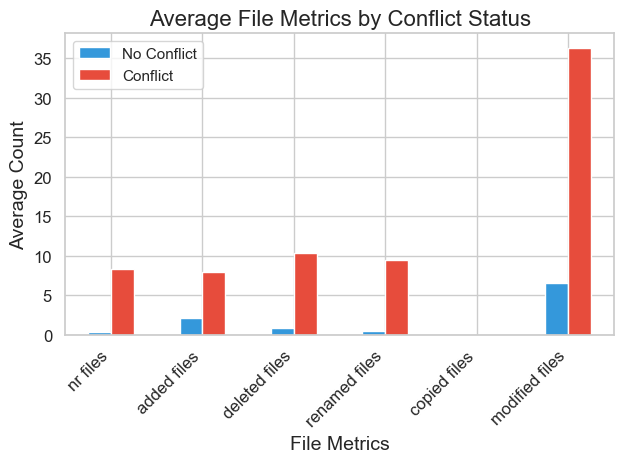

In [ ]:
# Visualize file metrics
plt.figure(figsize=(14, 7))
file_metrics_by_conflict.T.plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Average File Metrics by Conflict Status', fontsize=16)
plt.xlabel('File Metrics', fontsize=14)
plt.ylabel('Average Count', fontsize=14)
plt.legend(['No Conflict', 'Conflict'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('file_metrics_by_conflict')
plt.show()

Saving figure feature_pairplot


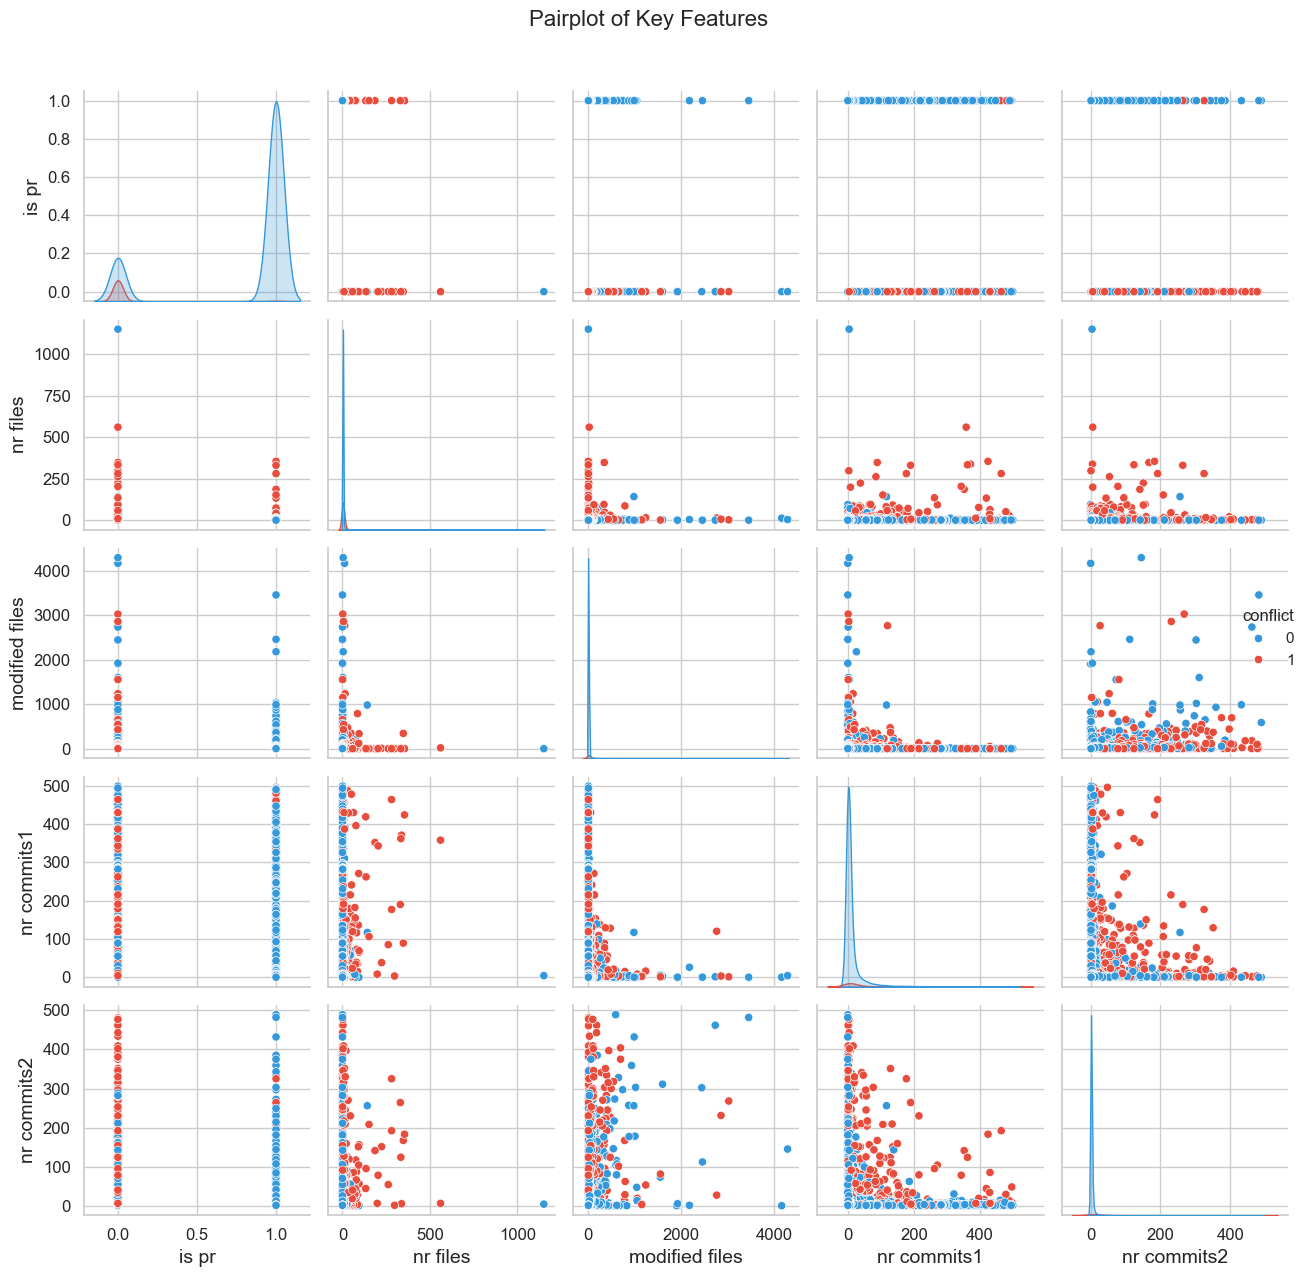

In [ ]:
# Create a pairplot for the most important features
important_features = ['is pr', 'nr files', 'modified files', 'nr commits1', 'nr commits2', 'conflict']
sns.pairplot(df[important_features], hue='conflict', palette=['#3498db', '#e74c3c'])
plt.suptitle('Pairplot of Key Features', y=1.02, fontsize=16)
save_fig('feature_pairplot')
plt.show()

# Data Preprocessing, Scaling and Encoding

Data preprocessing steps are critical for this dataset due to:
1. Wide range of values across features (e.g., added lines from 0 to >1M)
2. Different units and scales for different features
3. Potential impact of extreme values on distance-based algorithms like SVM
4. Need to handle the class imbalance problem (only 5.44% conflicts)

Preprocessing approach:
- StandardScaler for feature normalization (mean=0, std=1)
- No explicit encoding needed as all features are already numeric
- Will address class imbalance through SMOTE during model training
- Outliers are preserved as they represent complex merges that are more likely to cause conflicts

## Check Feature Ranges

In [ ]:
# Print feature ranges before scaling
print("\nFeature ranges before scaling:")
for feature in ['added lines', 'deleted lines', 'time', 'nr files', 'modified files']:
    print(f"{feature}: Min={X[feature].min()}, Max={X[feature].max()}, Mean={X[feature].mean():.2f}, Median={X[feature].median()}")



Feature ranges before scaling:
added lines: Min=0, Max=1140945, Mean=425.57, Median=11.0
deleted lines: Min=0, Max=1140456, Mean=250.43, Median=2.0
time: Min=0, Max=21513, Mean=240.71, Median=36.0
nr files: Min=0, Max=1152, Mean=0.75, Median=0.0
modified files: Min=0, Max=4289, Mean=8.17, Median=1.0


## Feature Scaling

Many features have widely different scales:
- `added lines` and `deleted_lines` range from 0 to over 1,140,000
- `time` ranges from 0 to over 21,000 hours
- Other features like `is pr` are binary (0 or 1)

This range disparity makes scaling necessary, especially for algorithms sensitive to feature magnitudes (like SVM). We'll use StandardScaler to normalize all features to zero mean and unit variance.

After scaling, all features have comparable magnitudes around zero with a standard deviation of 1, ensuring that no feature dominates the models due to its scale alone.

In [30]:
# Apply StandardScaler to features
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[feature_cols] = scaler.fit_transform(X[feature_cols])

print("\nFeature ranges after scaling:")
for feature in ['added lines', 'deleted lines', 'time', 'nr files', 'modified files']:
    print(f"{feature}: Min={X_scaled[feature].min():.2f}, Max={X_scaled[feature].max():.2f}, Mean={X_scaled[feature].mean():.2f}, StdDev={X_scaled[feature].std():.2f}")


Feature ranges after scaling:
added lines: Min=-0.05, Max=128.33, Mean=-0.00, StdDev=1.00
deleted lines: Min=-0.02, Max=110.93, Mean=0.00, StdDev=1.00
time: Min=-0.26, Max=23.42, Mean=0.00, StdDev=1.00
nr files: Min=-0.07, Max=108.40, Mean=0.00, StdDev=1.00
modified files: Min=-0.11, Max=57.13, Mean=-0.00, StdDev=1.00


# Train/Test Split with Stratification

Due to the significant class imbalance (5.44% conflicts), stratification is essential in our train/test split:

**Why stratification matters:**
- Without stratification, random sampling might result in too few conflict examples in the test set
- This would make evaluation unreliable and potentially misleading
- Stratification ensures both training and test sets maintain the same class distribution

We use an 80/20 train/test split with stratification on the target variable. The result confirms identical conflict ratios in both sets (5.44%), providing a solid foundation for model training and evaluation.


In [31]:
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set conflict ratio: {100 * y_train.mean():.2f}%")
print(f"Test set conflict ratio: {100 * y_test.mean():.2f}%")


Training set shape: (21578, 32), Test set shape: (5395, 32)
Training set conflict ratio: 5.44%
Test set conflict ratio: 5.45%


Saving figure train_test_distribution


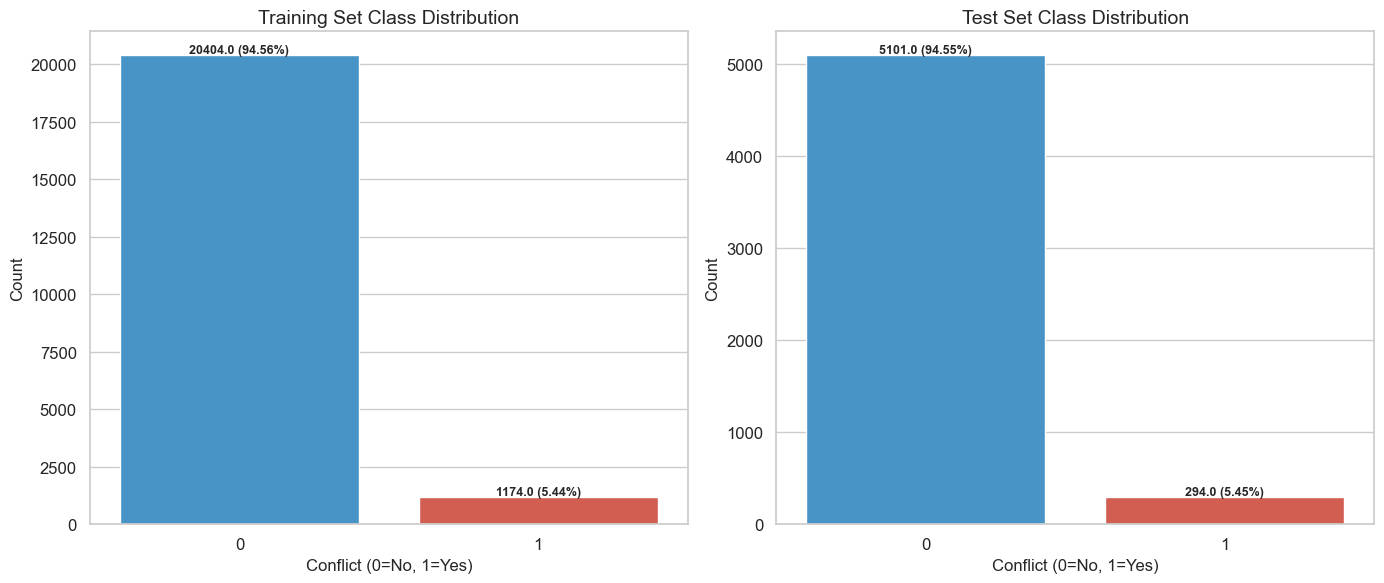

In [11]:
# Visualize class distribution in train and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
train_counts = y_train.value_counts()
ax1 = sns.countplot(x=y_train, palette=['#3498db', '#e74c3c'])
plt.title('Training Set Class Distribution', fontsize=14)
plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentages on training set bars
for i, p in enumerate(ax1.patches):
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2., height + 100,
            f'{height} ({height/len(y_train)*100:.2f}%)', 
            ha="center", fontsize=9, fontweight='bold')

plt.subplot(1, 2, 2)
test_counts = y_test.value_counts()
ax2 = sns.countplot(x=y_test, palette=['#3498db', '#e74c3c'])
plt.title('Test Set Class Distribution', fontsize=14)
plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentages on test set bars
for i, p in enumerate(ax2.patches):
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height + 20,
            f'{height} ({height/len(y_test)*100:.2f}%)', 
            ha="center", fontsize=9, fontweight='bold')

plt.tight_layout()
save_fig('train_test_distribution')
plt.show()


# Performance Metric Selection

Due to severe class imbalance (5.44% conflicts vs. 94.56% non-conflicts):

1. Accuracy is misleading:
   - A model always predicting "no conflict" would achieve 94.56% accuracy, but would provide no value for detecting conflicts

2. Better metrics for imbalanced classification:
   - Precision: Proportion of predicted conflicts that are actually conflicts
   - Recall: Proportion of actual conflicts that were correctly identified
   - F1-score: Harmonic mean of precision and recall
   - ROC-AUC: Area under the ROC curve, measuring discrimination ability

3. Primary metric selection:
   - We choose F1-score as the main optimization metric to balance precision and recall
   - This reflects a balanced approach where both false positives and false negatives are important

In [34]:
# Define evaluation function with appropriate metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train model and evaluate performance using multiple metrics"""
    # Train the model (if not already trained)
    if not hasattr(model, 'classes_'):
        model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Print results
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()
    
    # Plot ROC curve if probabilities are available
    # if y_pred_proba is not None:
    #     plt.figure(figsize=(8, 6))
    #     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    #     auc_score = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    #     plt.plot([0, 1], [0, 1], 'k--', lw=2)
    #     plt.xlim([0.0, 1.0])
    #     plt.ylim([0.0, 1.05])
    #     plt.xlabel('False Positive Rate', fontsize=14)
    #     plt.ylabel('True Positive Rate', fontsize=14)
    #     plt.title(f'ROC Curve - {model_name}', fontsize=16)
    #     plt.legend(loc="lower right")
    #     plt.show()
        
    #     # Precision-Recall curve (more informative for imbalanced data)
    #     plt.figure(figsize=(8, 6))
    #     precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_proba)
    #     plt.plot(recall_values, precision_values, lw=2)
    #     plt.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'No Skill (y_mean={y_test.mean():.3f})')
    #     plt.xlabel('Recall', fontsize=14)
    #     plt.ylabel('Precision', fontsize=14)
    #     plt.title(f'Precision-Recall Curve - {model_name}', fontsize=16)
    #     plt.legend()
    #     plt.show()
        
    return model, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Feature Selection for Slim Models

Given the large number of features (32), feature selection can help create more efficient models by:
- Reducing overfitting by removing irrelevant features
- Improving model interpretability
- Decreasing training time
- Reduces dimensionality, particularly helpful for SVM

We'll use feature importance from Random Forest to select the most relevant features.

In [35]:
# Feature Selection using Random Forest Importance
print("\nPerforming feature selection...")

# Create a Random Forest classifier to evaluate feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {feature_cols[indices[f]]} ({importances[indices[f]]:.5f})")




Performing feature selection...

Feature ranking:
1. nr files (0.28852)
2. is pr (0.25897)
3. nr commits1 (0.06800)
4. devs parent1 (0.05282)
5. nr commits2 (0.05075)
6. add (0.02891)
7. devs parent2 (0.02760)
8. messages_min (0.02649)
9. added lines (0.02357)
10. messages_mean (0.01790)
11. deleted lines (0.01643)
12. messages_median (0.01579)
13. modified files (0.01519)
14. time (0.01438)
15. messages_max (0.01420)
16. fix (0.01307)
17. density2 (0.01085)
18. density1 (0.00776)
19. update (0.00699)
20. remove (0.00615)
21. change (0.00576)
22. use (0.00452)
23. refactor (0.00426)
24. added files (0.00418)
25. bug (0.00415)
26. improve (0.00378)
27. document (0.00236)
28. feature (0.00192)
29. renamed files (0.00186)
30. deleted files (0.00162)
31. delete (0.00123)
32. copied files (0.00000)


Saving figure feature_importances


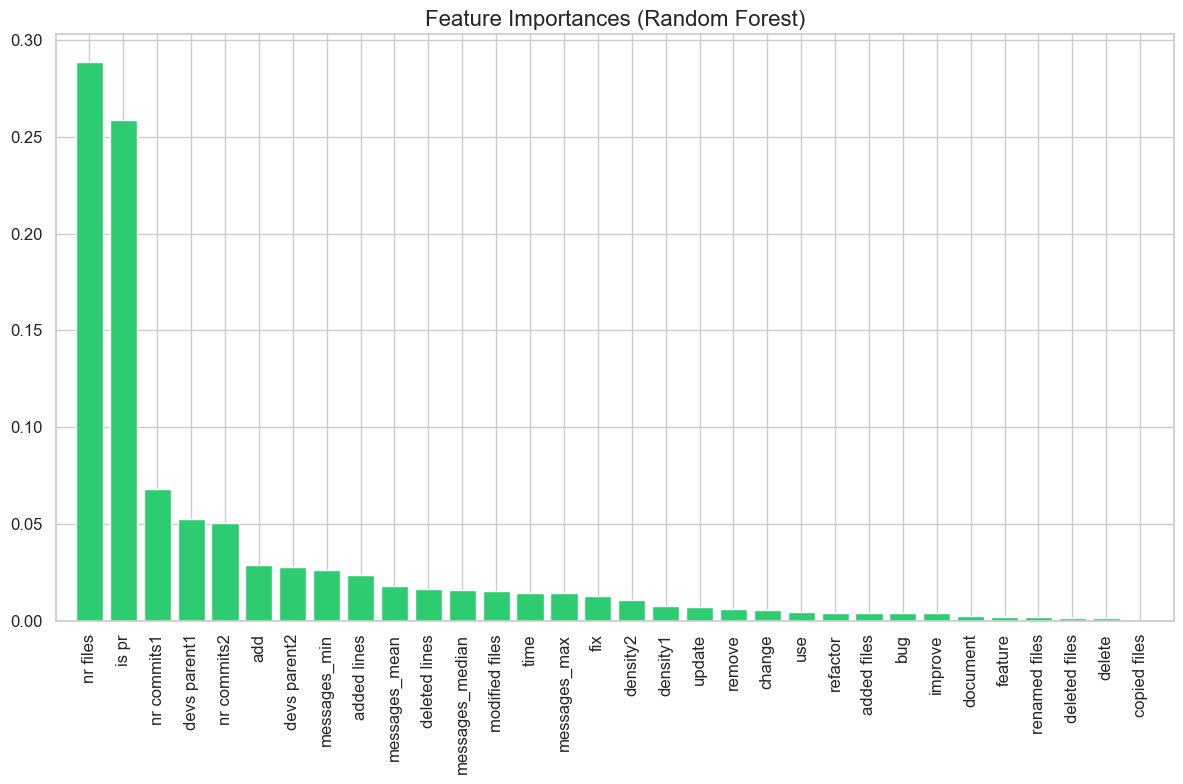

In [166]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Random Forest)", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], color='#2ecc71', align="center")
plt.xticks(range(X_train.shape[1]), [feature_cols[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
save_fig('feature_importances')
plt.show()

In [36]:
# Select top 15 features based on importance
top_features = 15
selected_features = [feature_cols[i] for i in indices[:top_features]]
print(f"\nSelected top {top_features} features:")
print(selected_features)


Selected top 15 features:
['nr files', 'is pr', 'nr commits1', 'devs parent1', 'nr commits2', 'add', 'devs parent2', 'messages_min', 'added lines', 'messages_mean', 'deleted lines', 'messages_median', 'modified files', 'time', 'messages_max']


In [37]:
# Update training and test sets with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Model Selection, Training and Oprimization

We'll implement multiple classifier types as required:
- Decision Tree: Interpretable, handles non-linear relationships
- Naive Bayes: Fast, probabilistic, different theoretical approach
- Random Forest: Ensemble method that reduces overfitting
- AdaBoost: Boosting ensemble that focuses on difficult examples

For each model, we'll:
- Perform hyperparameter tuning with GridSearchCV
- Evaluate on training set with cross-validation
- Assess performance on test set
- Check for overfitting/underfitting

## Decision Tree Classifier


Training Decision Tree Classifier...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Decision Tree parameters: {'dt__class_weight': None, 'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
Best F1-score (CV): 0.6707

Decision Tree Evaluation:
Accuracy: 0.9531
Precision: 0.5432
Recall: 0.8776
F1-score: 0.6710
ROC-AUC: 0.9415

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5101
           1       0.54      0.88      0.67       294

    accuracy                           0.95      5395
   macro avg       0.77      0.92      0.82      5395
weighted avg       0.97      0.95      0.96      5395



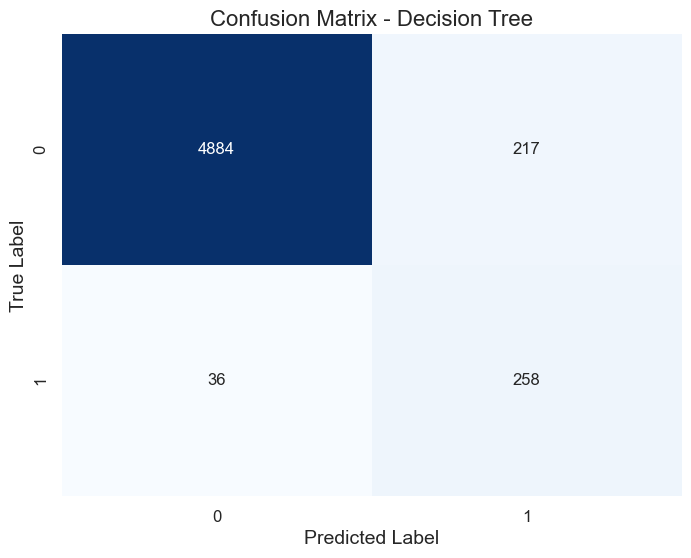

In [38]:
# Decision Tree with Grid Search
print("\nTraining Decision Tree Classifier...")

# Create pipeline with SMOTE and Decision Tree
dt_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Parameter grid for tuning
dt_param_grid = {
    'dt__max_depth': [3, 5, 7, 10, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__class_weight': [None, 'balanced']
}

# Grid search with cross-validation
dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_selected, y_train)

# Best parameters and score
print(f"\nBest Decision Tree parameters: {dt_grid.best_params_}")
print(f"Best F1-score (CV): {dt_grid.best_score_:.4f}")

# Evaluate on test set
best_dt = dt_grid.best_estimator_
dt_model, dt_metrics = evaluate_model(best_dt, X_train_selected, X_test_selected, y_train, y_test, "Decision Tree")

## Naive Bayes Classifier


Training Naive Bayes Classifier...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Naive Bayes parameters: {'nb__var_smoothing': 1e-09}
Best F1-score (CV): 0.4564

Naive Bayes Evaluation:
Accuracy: 0.9362
Precision: 0.4081
Recall: 0.3776
F1-score: 0.3922
ROC-AUC: 0.9405

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5101
           1       0.41      0.38      0.39       294

    accuracy                           0.94      5395
   macro avg       0.69      0.67      0.68      5395
weighted avg       0.93      0.94      0.94      5395



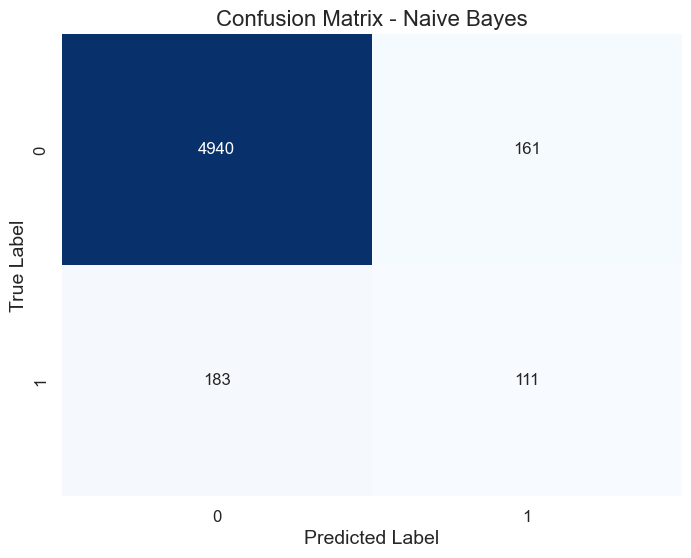

In [39]:
# Naive Bayes with Grid Search
print("\nTraining Naive Bayes Classifier...")

# Create pipeline with SMOTE and Naive Bayes
nb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB())
])

# Parameter grid for tuning
nb_param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Grid search with cross-validation
nb_grid = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
nb_grid.fit(X_train_selected, y_train)

# Best parameters and score
print(f"\nBest Naive Bayes parameters: {nb_grid.best_params_}")
print(f"Best F1-score (CV): {nb_grid.best_score_:.4f}")

# Evaluate on test set
best_nb = nb_grid.best_estimator_
nb_model, nb_metrics = evaluate_model(best_nb, X_train_selected, X_test_selected, y_train, y_test, "Naive Bayes")

## Random Forest Classifier


Training Random Forest Classifier...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Random Forest parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best F1-score (CV): 0.7099

Random Forest Evaluation:
Accuracy: 0.9659
Precision: 0.6463
Recall: 0.8265
F1-score: 0.7254
ROC-AUC: 0.9807

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5101
           1       0.65      0.83      0.73       294

    accuracy                           0.97      5395
   macro avg       0.82      0.90      0.85      5395
weighted avg       0.97      0.97      0.97      5395



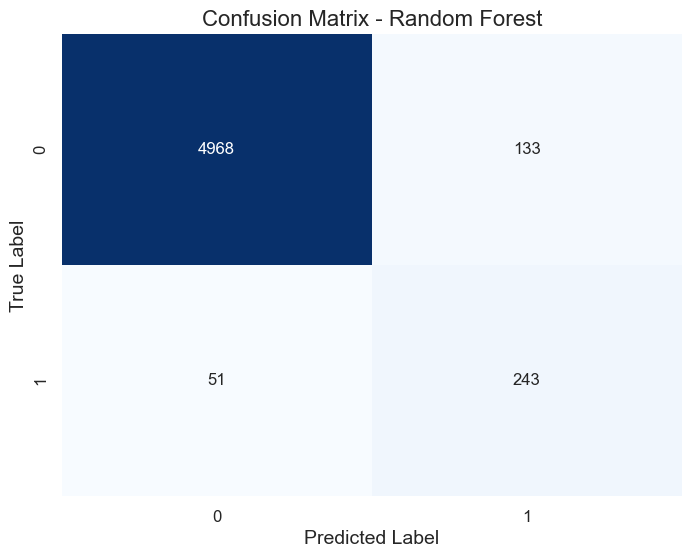

In [40]:
# Random Forest with Grid Search
print("\nTraining Random Forest Classifier...")

# Create pipeline with SMOTE and Random Forest
rf_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Parameter grid for tuning
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

# Grid search with cross-validation
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_selected, y_train)

# Best parameters and score
print(f"\nBest Random Forest parameters: {rf_grid.best_params_}")
print(f"Best F1-score (CV): {rf_grid.best_score_:.4f}")

# Evaluate on test set
best_rf = rf_grid.best_estimator_
rf_model, rf_metrics = evaluate_model(best_rf, X_train_selected, X_test_selected, y_train, y_test, "Random Forest")

## AdaBoost Classifier


Training AdaBoost Classifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best AdaBoost parameters: {'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 1.0, 'ada__n_estimators': 200}
Best F1-score (CV): 0.6725

AdaBoost Evaluation:
Accuracy: 0.9564
Precision: 0.5632
Recall: 0.8946
F1-score: 0.6912
ROC-AUC: 0.9795

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5101
           1       0.56      0.89      0.69       294

    accuracy                           0.96      5395
   macro avg       0.78      0.93      0.83      5395
weighted avg       0.97      0.96      0.96      5395



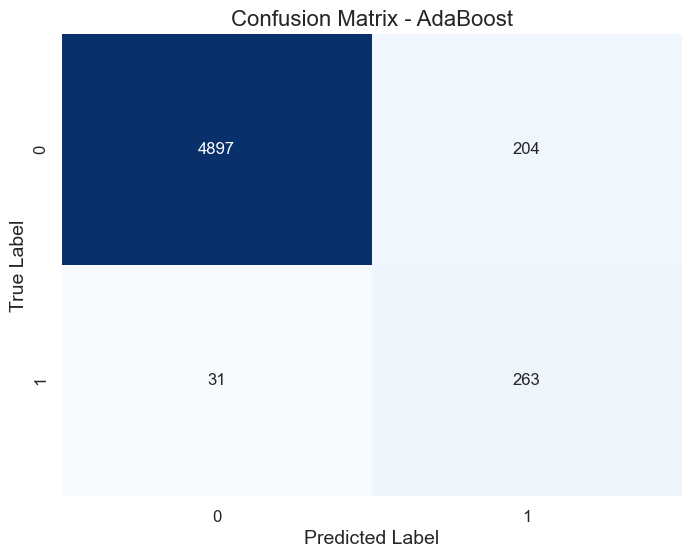

In [41]:
# AdaBoost with Grid Search
print("\nTraining AdaBoost Classifier...")

# Create pipeline with SMOTE and AdaBoost
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42))
])

# Parameter grid for tuning
ada_param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.1, 1.0],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

# Grid search with cross-validation
ada_grid = GridSearchCV(ada_pipeline, ada_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
ada_grid.fit(X_train_selected, y_train)

# Best parameters and score
print(f"\nBest AdaBoost parameters: {ada_grid.best_params_}")
print(f"Best F1-score (CV): {ada_grid.best_score_:.4f}")

# Evaluate on test set
best_ada = ada_grid.best_estimator_
ada_model, ada_metrics = evaluate_model(best_ada, X_train_selected, X_test_selected, y_train, y_test, "AdaBoost")

## Model Comparison and Analysis


Model Comparison:
               accuracy  precision    recall        f1   roc_auc
Random Forest  0.965894   0.646277  0.826531  0.725373  0.980666
AdaBoost       0.956441   0.563169  0.894558  0.691196  0.979513
Decision Tree  0.953105   0.543158  0.877551  0.671001  0.941537
Naive Bayes    0.936237   0.408088  0.377551  0.392226  0.940475
Saving figure model_comparison


<Figure size 1200x800 with 0 Axes>

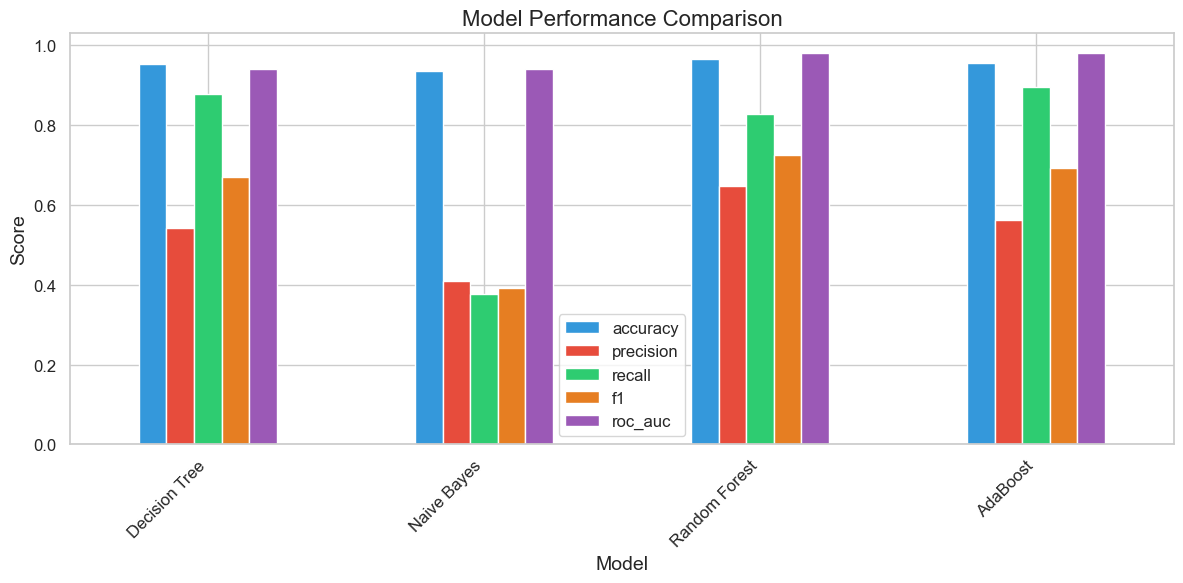

In [33]:
# Compare model performance
models_metrics = {
    'Decision Tree': dt_metrics,
    #'Support Vector Machine': svm_metrics,
    'Naive Bayes': nb_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics
}

metrics_df = pd.DataFrame(models_metrics).T
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

print("\nModel Comparison:")
print(metrics_df.sort_values('f1', ascending=False))

# Plot performance comparison
plt.figure(figsize=(12, 8))
# metrics_df[['precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 6), 
#                                               color=['#3498db', '#e74c3c', '#2ecc71'])
metrics_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].plot(kind='bar', figsize=(12, 6), 
                                               color=['#3498db', '#e74c3c', '#2ecc71', '#e67e22', '#9b59b6'])
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
save_fig('model_comparison')
plt.show()

## Overfitting Analysis

In [ ]:
# Function to assess overfitting using cross-validation
def evaluate_overfitting(model, X_train, y_train, model_name):
    """Assess overfitting by comparing training and cross-validation performance"""
    # Training performance
    train_pred = model.predict(X_train)
    train_f1 = f1_score(y_train, train_pred)
    
    # Cross-validation performance
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"\n{model_name} Overfitting Analysis:")
    print(f"Training F1-score: {train_f1:.4f}")
    print(f"5-fold CV F1-score: {cv_mean:.4f} (±{cv_std:.4f})")
    print(f"Difference (Train - CV): {train_f1 - cv_mean:.4f}")
    
    if train_f1 - cv_mean > 0.1:
        print("Status: Potential overfitting (training performance significantly better than CV)")
    elif cv_mean < 0.3: 
        print("Status: Potential underfitting (model struggles to learn patterns)")
    else:
        print("Status: Good fit (balanced training and CV performance)")
    
    return {
        'train_f1': train_f1,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'difference': train_f1 - cv_mean
    }


Decision Tree Overfitting Analysis:
Training F1-score: 0.7215
5-fold CV F1-score: 0.6707 (±0.0208)
Difference (Train - CV): 0.0507
Status: Good fit (balanced training and CV performance)

Naive Bayes Overfitting Analysis:
Training F1-score: 0.4505
5-fold CV F1-score: 0.4564 (±0.0290)
Difference (Train - CV): -0.0059
Status: Good fit (balanced training and CV performance)

Random Forest Overfitting Analysis:
Training F1-score: 0.9987
5-fold CV F1-score: 0.7099 (±0.0179)
Difference (Train - CV): 0.2888
Status: Potential overfitting (training performance significantly better than CV)

AdaBoost Overfitting Analysis:
Training F1-score: 0.6881
5-fold CV F1-score: 0.6725 (±0.0100)
Difference (Train - CV): 0.0156
Status: Good fit (balanced training and CV performance)
Saving figure overfitting_analysis


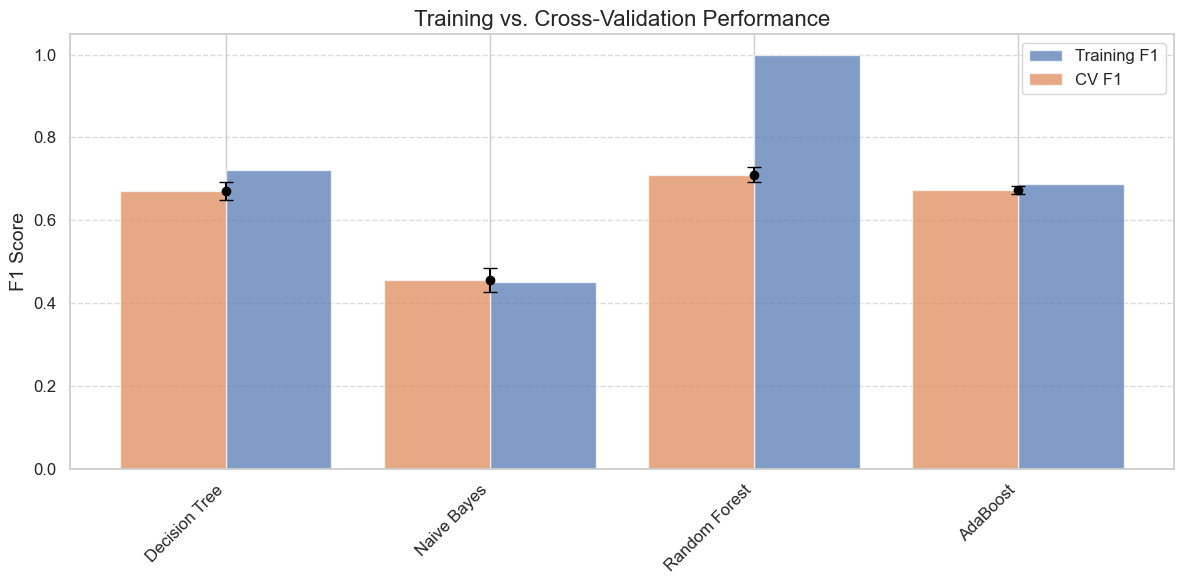

In [29]:
# Check for overfitting/underfitting
dt_overfit = evaluate_overfitting(dt_grid.best_estimator_, X_train_selected, y_train, "Decision Tree")
#svm_overfit = evaluate_overfitting(svm_grid.best_estimator_, X_train_selected, y_train, "Support Vector Machine")
nb_overfit = evaluate_overfitting(nb_grid.best_estimator_, X_train_selected, y_train, "Naive Bayes")
rf_overfit = evaluate_overfitting(rf_grid.best_estimator_, X_train_selected, y_train, "Random Forest")
ada_overfit = evaluate_overfitting(ada_grid.best_estimator_, X_train_selected, y_train, "AdaBoost")

# Visualize overfitting analysis
overfitting_df = pd.DataFrame({
    'Decision Tree': dt_overfit,
    #'SVM': svm_overfit,
    'Naive Bayes': nb_overfit,
    'Random Forest': rf_overfit,
    'AdaBoost': ada_overfit
}).T

plt.figure(figsize=(12, 6))
plt.bar(overfitting_df.index, overfitting_df['train_f1'], width=0.4, label='Training F1', align='edge', alpha=0.7)
plt.bar(overfitting_df.index, overfitting_df['cv_mean'], width=-0.4, label='CV F1', align='edge', alpha=0.7)
plt.errorbar(overfitting_df.index, overfitting_df['cv_mean'], 
            yerr=overfitting_df['cv_std'], fmt='o', color='black', capsize=5)
plt.title('Training vs. Cross-Validation Performance', fontsize=16)
plt.ylabel('F1 Score', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('overfitting_analysis')
plt.show()

# New Features Proposal 

Feature engineering is crucial for enhancing model performance by:
1. Creating more informative representations of the existing data
2. Capturing domain knowledge in numerical form
3. Highlighting relationships that models might miss from raw features

Let's create some new features that might improve the model's predictive power:
1. **Ratio-based features**: Ratios often capture relative changes that may be more informative than absolute values
2. **Interaction features**: Combining features that might work together to predict conflicts
3. **Aggregate features**: Summaries of multiple related features
4. **Domain-specific complexity indicators**


In [8]:
# Create a copy of the original dataframe for feature engineering
df_new = df.copy()

In [9]:
# 1. Create ratio-based features
print("\nCreating new ratio-based features...")
# Developer ratio (imbalance between branches)
df_new['dev_ratio'] = df_new['devs parent1'] / (df_new['devs parent2'] + 1e-6)
df_new['dev_ratio'] = df_new['dev_ratio'].replace([np.inf, -np.inf], 10)  # Handle division by zero

# Commit ratio (imbalance between branches)
df_new['commit_ratio'] = df_new['nr commits1'] / (df_new['nr commits2'] + 1e-6)
df_new['commit_ratio'] = df_new['commit_ratio'].replace([np.inf, -np.inf], 10)  # Handle division by zero

# Density ratio (imbalance in commit density)
df_new['density_ratio'] = df_new['density1'] / (df_new['density2'] + 1e-6)
df_new['density_ratio'] = df_new['density_ratio'].replace([np.inf, -np.inf], 10)  # Handle division by zero

# Line changes per file
df_new['lines_per_file'] = (df_new['added lines'] + df_new['deleted lines']) / (df_new['nr files'] + 1e-6)
df_new['lines_per_file'] = df_new['lines_per_file'].replace([np.inf, -np.inf], 1000)  # Handle division by zero



Creating new ratio-based features...


In [16]:
# 2. Create interaction features
print("Creating new interaction features...")
# Combined complexity metric
df_new['complexity'] = df_new['nr files'] * df_new['time'] / 100

# Developer-commit interaction (more developers + more commits = more complexity)
df_new['dev_commit_interaction'] = (df_new['devs parent1'] + df_new['devs parent2']) * (df_new['nr commits1'] + df_new['nr commits2'])

# Time-weighted file changes
df_new['time_weighted_files'] = df_new['nr files'] * np.log1p(df_new['time'])

# File modification intensity (changes per time unit)
df_new['file_mod_intensity'] = df_new['modified files'] / (df_new['time'] + 1e-6)
df_new['file_mod_intensity'] = df_new['file_mod_intensity'].replace([np.inf, -np.inf], 100)  # Handle division by zero

# Developer density (developers per file)
df_new['dev_density'] = (df_new['devs parent1'] + df_new['devs parent2']) / (df_new['nr files'] + 1e-6)
df_new['dev_density'] = df_new['dev_density'].replace([np.inf, -np.inf], 10)  # Handle division by zero



Creating new interaction features...


In [11]:
# 3. Create aggregate features
print("Creating new aggregate features...")
# Total developers
df_new['total_devs'] = df_new['devs parent1'] + df_new['devs parent2']

# Total commits
df_new['total_commits'] = df_new['nr commits1'] + df_new['nr commits2']

# Total commit message keywords (indication of change types)
keyword_cols = ['fix', 'bug', 'feature', 'improve', 'document', 'refactor', 
                'update', 'add', 'remove', 'use', 'delete', 'change']
df_new['total_keywords'] = df_new[keyword_cols].sum(axis=1)

# Message quality (average length indicates better documentation)
df_new['msg_quality'] = df_new['messages_mean'] / (df_new['messages_max'] + 1e-6)
df_new['msg_quality'] = df_new['msg_quality'].replace([np.inf, -np.inf], 1)  # Handle division by zero

# Feature to capture file operations complexity
df_new['file_ops_complexity'] = df_new['added files'] + df_new['deleted files'] + 2*df_new['modified files'] + 3*df_new['renamed files']


Creating new aggregate features...


In [13]:
# 4. Domain-specific features
# Weighted PR influence - Give more weight to PRs in complex scenarios
df_new['pr_weight'] = df_new['is pr'] * (1 + np.log1p(df_new['nr files'] + df_new['time']/100))

# Commit message quality to file ratio
df_new['msg_quality_per_file'] = df_new['messages_mean'] / (df_new['nr files'] + 1e-6)
df_new['msg_quality_per_file'] = df_new['msg_quality_per_file'].replace([np.inf, -np.inf], 10)  # Handle division by zero

In [19]:
# Display new features
new_features = [
    'dev_ratio', 'commit_ratio', 'density_ratio', 'lines_per_file', 
    'complexity', 'dev_commit_interaction', 'time_weighted_files', 
    'file_mod_intensity', 'dev_density', 'total_devs', 'total_commits',
    'total_keywords', 'msg_quality', 'file_ops_complexity',
    'pr_weight', 'msg_quality_per_file'
]

print("\nNew features created:")
for i, feature in enumerate(new_features):
    print(f"{i+1}. {feature}")


New features created:
1. dev_ratio
2. commit_ratio
3. density_ratio
4. lines_per_file
5. complexity
6. dev_commit_interaction
7. time_weighted_files
8. file_mod_intensity
9. dev_density
10. total_devs
11. total_commits
12. total_keywords
13. msg_quality
14. file_ops_complexity
15. pr_weight
16. msg_quality_per_file


In [20]:
# Calculate correlation of new features with target
correlation_with_target = df_new[new_features].corrwith(df_new['conflict']).sort_values(ascending=False)
print("\nCorrelation of new features with target:")
print(correlation_with_target)


Correlation of new features with target:
total_commits             0.234836
time_weighted_files       0.220037
total_keywords            0.215524
total_devs                0.195964
dev_commit_interaction    0.168313
complexity                0.144024
file_ops_complexity       0.081674
file_mod_intensity        0.030853
commit_ratio             -0.002174
dev_ratio                -0.002573
density_ratio            -0.004839
lines_per_file           -0.007899
dev_density              -0.105905
msg_quality              -0.218715
msg_quality_per_file     -0.270894
pr_weight                -0.296275
dtype: float64


Saving figure new_feature_correlations


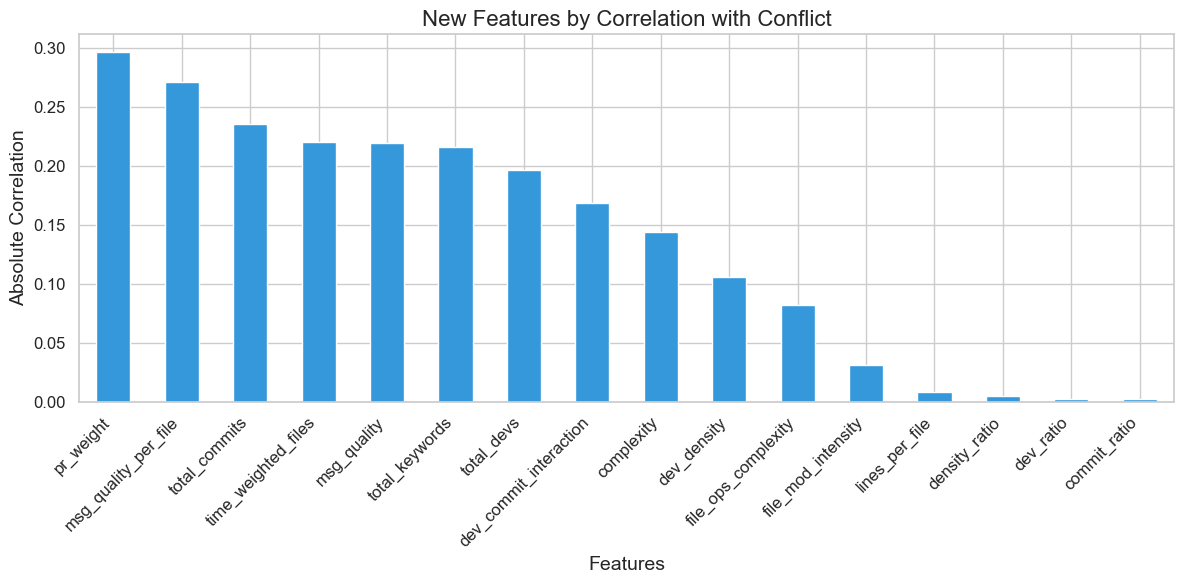

In [21]:
# Visualize top new features by correlation
plt.figure(figsize=(12, 6))
correlation_with_target.abs().sort_values(ascending=False).plot(kind='bar', color='#3498db')
plt.title('New Features by Correlation with Conflict', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Absolute Correlation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_fig('new_feature_correlations')
plt.show()

Saving figure new_feature_boxplots


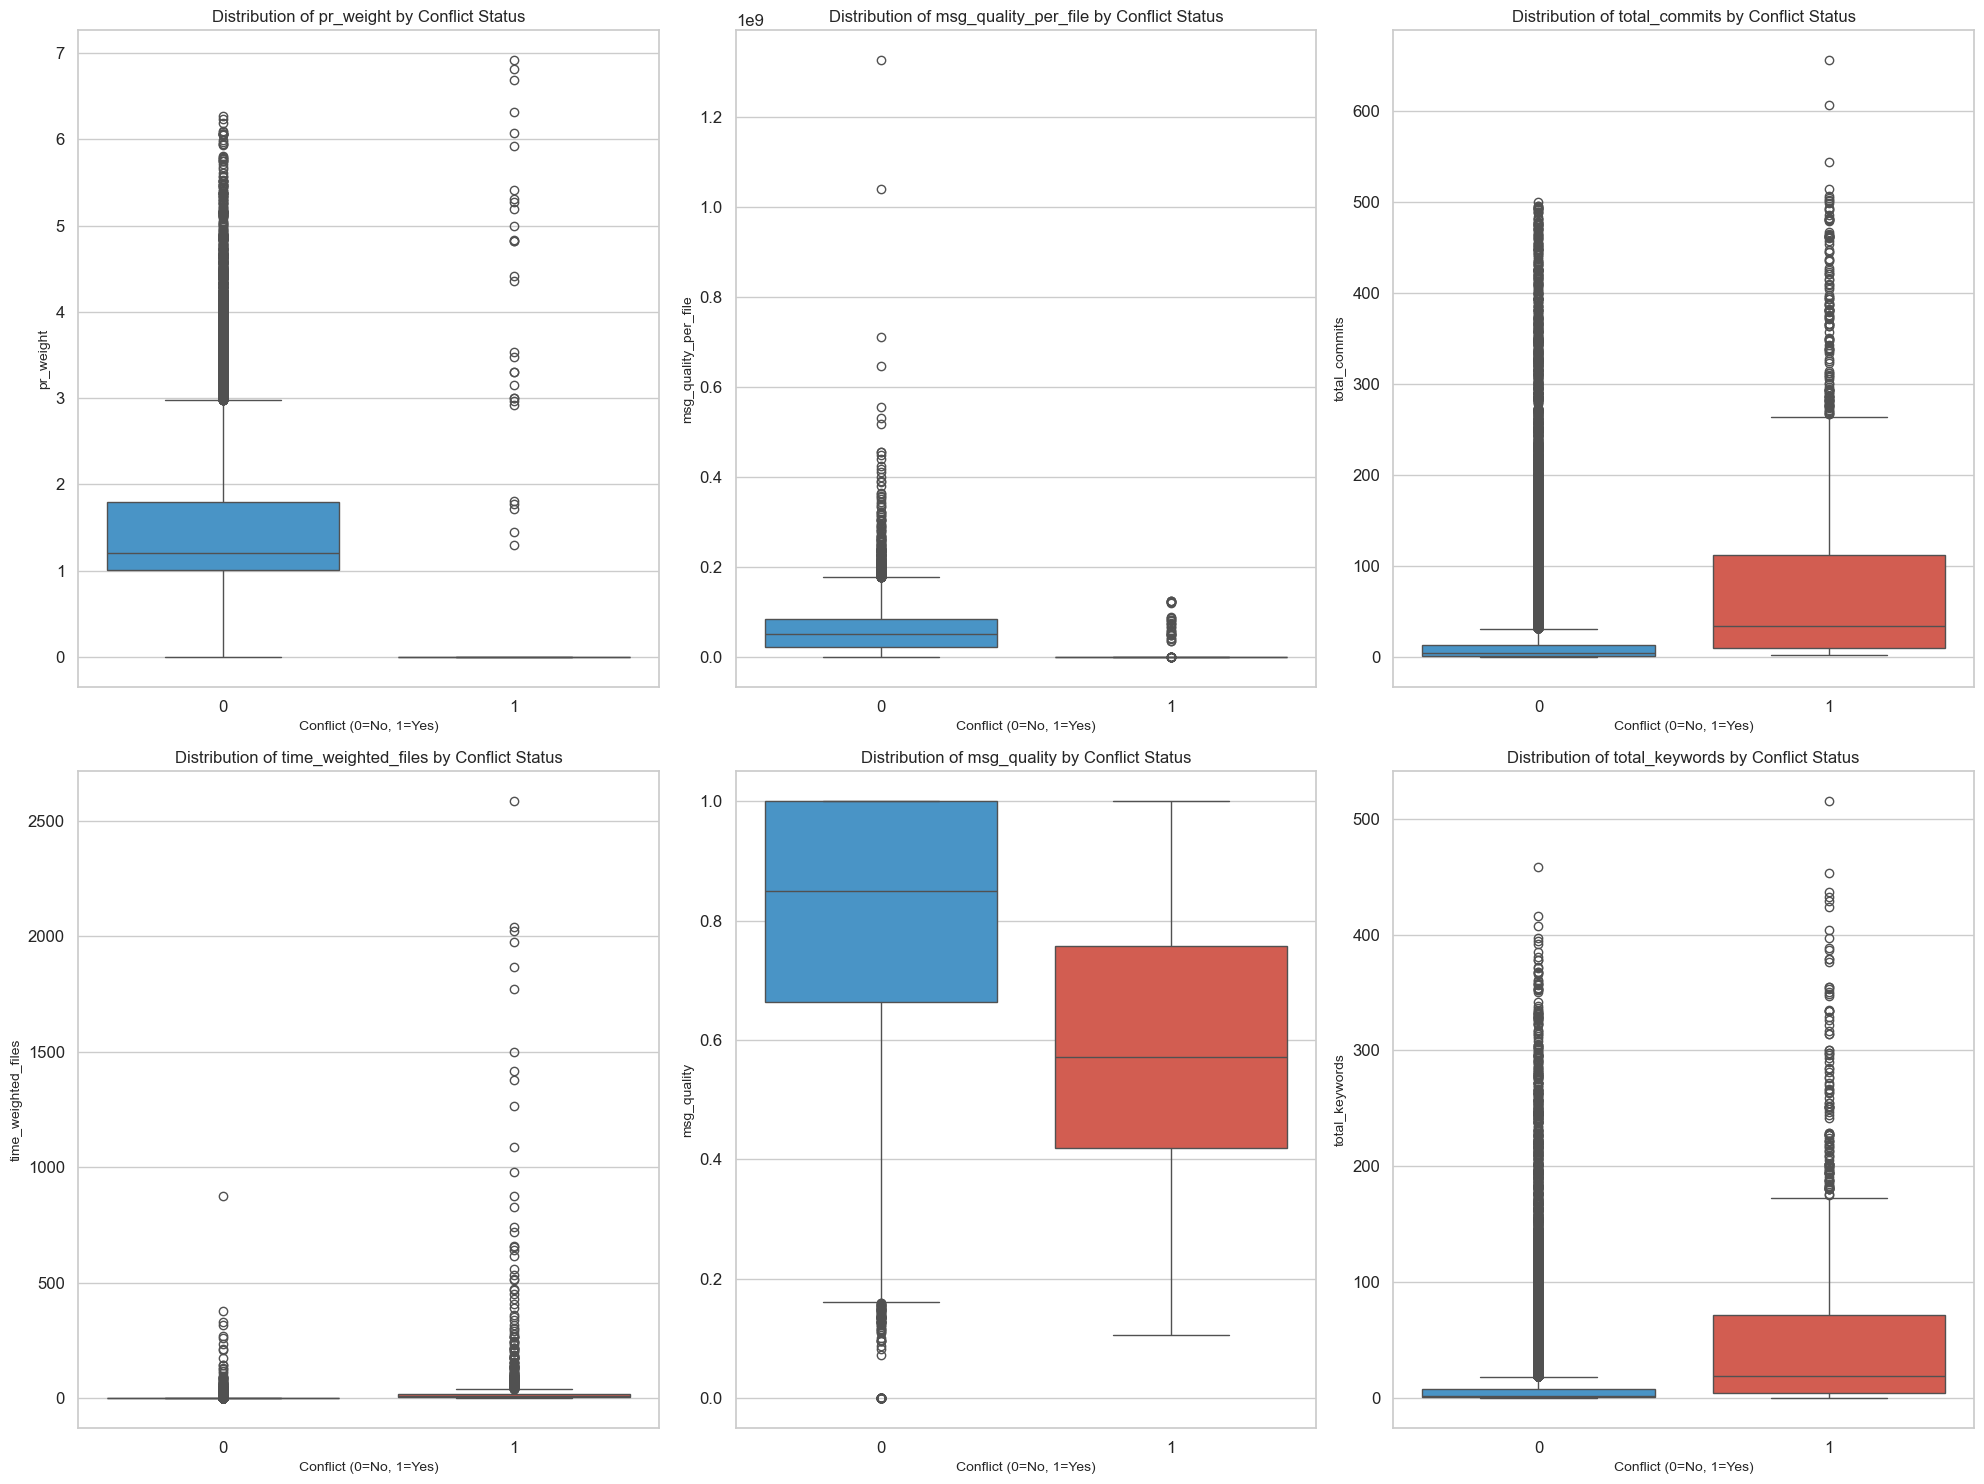

In [22]:
# Plot distributions of top new features by conflict status
plt.figure(figsize=(20, 15))
top_new_features = correlation_with_target.abs().sort_values(ascending=False).head(6).index.tolist()

for i, feature in enumerate(top_new_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='conflict', y=feature, data=df_new, palette=['#3498db', '#e74c3c'])
    plt.title(f'Distribution of {feature} by Conflict Status', fontsize=12)
    plt.xlabel('Conflict (0=No, 1=Yes)', fontsize=10)
    plt.ylabel(feature, fontsize=10)
    
plt.tight_layout()
save_fig('new_feature_boxplots')
plt.show()

# Model Evaluation with New Features

In [23]:
# Prepare new feature set
X_new = df_new.drop(['commit', 'parent1', 'parent2', 'ancestor', 'conflict'], axis=1)
y_new = df_new['conflict']

In [24]:
# Train-test split with stratification
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42, stratify=y_new
)

In [25]:
# Feature selection with new features
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_selector.fit(X_train_new, y_train_new)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [26]:
# Get feature importances
importances_new = rf_selector.feature_importances_
indices_new = np.argsort(importances_new)[::-1]

Saving figure new_feature_importances


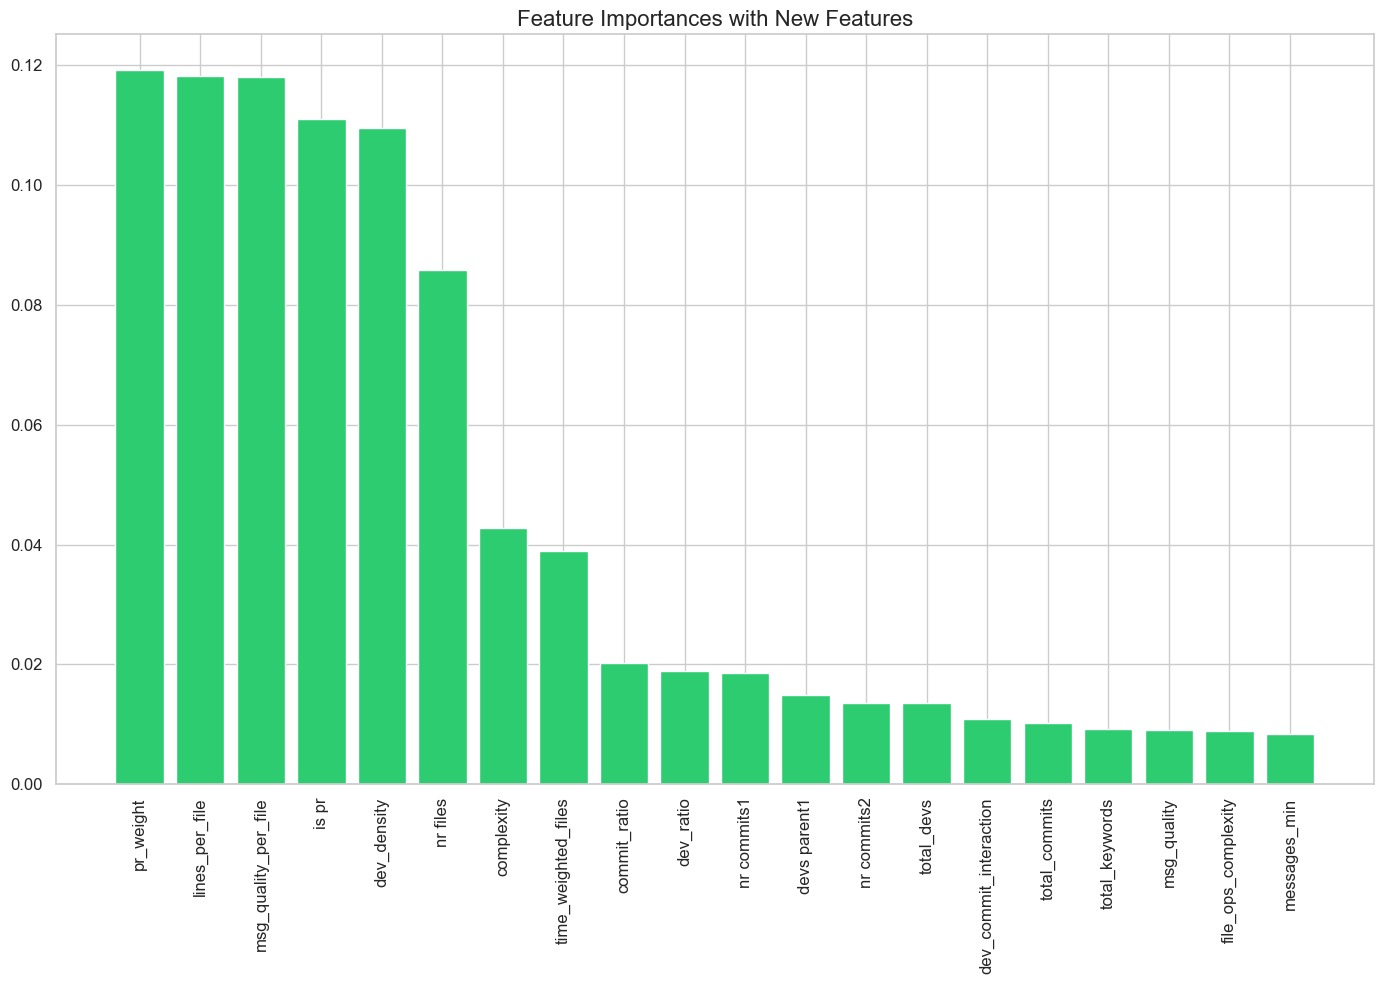

In [27]:
# Plot new feature importances
plt.figure(figsize=(14, 10))
plt.title("Feature Importances with New Features", fontsize=16)
plt.bar(range(20), importances_new[indices_new][:20], color='#2ecc71', align="center")
plt.xticks(range(20), [X_new.columns[i] for i in indices_new][:20], rotation=90)
plt.tight_layout()
save_fig('new_feature_importances')
plt.show()

In [28]:
# Select top 20 features
selected_features_new = [X_new.columns[i] for i in indices_new[:20]]
print(f"\nSelected top 20 features including engineered features:")
print(selected_features_new)

# Create selected feature sets
X_train_new_selected = X_train_new[selected_features_new]
X_test_new_selected = X_test_new[selected_features_new]


Selected top 20 features including engineered features:
['pr_weight', 'lines_per_file', 'msg_quality_per_file', 'is pr', 'dev_density', 'nr files', 'complexity', 'time_weighted_files', 'commit_ratio', 'dev_ratio', 'nr commits1', 'devs parent1', 'nr commits2', 'total_devs', 'dev_commit_interaction', 'total_commits', 'total_keywords', 'msg_quality', 'file_ops_complexity', 'messages_min']



Training Decision Tree Classifier with New Features...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Decision Tree parameters (New Features): {'dt__class_weight': None, 'dt__max_depth': 10, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5}
Best F1-score (CV): 0.6582

Decision Tree (New Features) Evaluation:
Accuracy: 0.9529
Precision: 0.5397
Recall: 0.9252
F1-score: 0.6817
ROC-AUC: 0.9655

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5101
           1       0.54      0.93      0.68       294

    accuracy                           0.95      5395
   macro avg       0.77      0.94      0.83      5395
weighted avg       0.97      0.95      0.96      5395



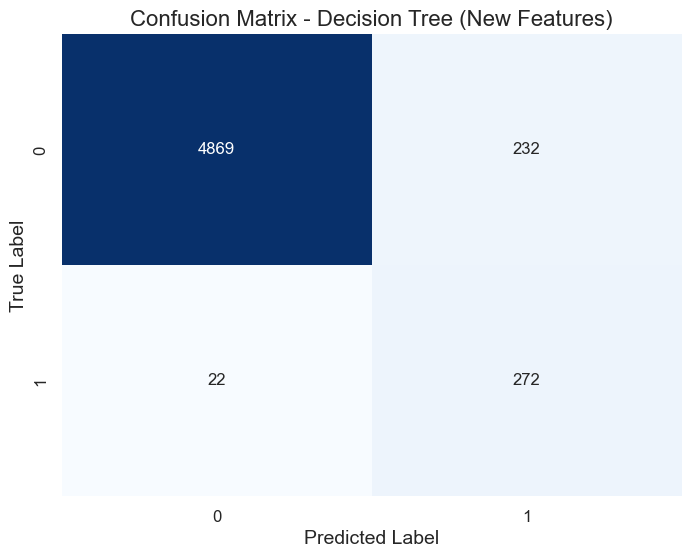

In [59]:
# Decision Tree with Grid Search for New Features
print("\nTraining Decision Tree Classifier with New Features...")

# Create pipeline with SMOTE and Decision Tree
dt_new_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Use the same parameter grid as the original features
dt_new_param_grid = {
    'dt__max_depth': [3, 5, 7, 10, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__class_weight': [None, 'balanced']
}

# Grid search with cross-validation
dt_new_grid = GridSearchCV(dt_new_pipeline, dt_new_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
dt_new_grid.fit(X_train_new_selected, y_train_new)

# Best parameters and score
print(f"\nBest Decision Tree parameters (New Features): {dt_new_grid.best_params_}")
print(f"Best F1-score (CV): {dt_new_grid.best_score_:.4f}")

# Evaluate on test set
best_dt_new = dt_new_grid.best_estimator_
dt_new_model, dt_new_metrics = evaluate_model(best_dt_new, X_train_new_selected, X_test_new_selected, 
                                          y_train_new, y_test_new, "Decision Tree (New Features)")



Training Naive Bayes Classifier with New Features...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Naive Bayes parameters (New Features): {'nb__var_smoothing': 1e-05}
Best F1-score (CV): 0.6107

Naive Bayes (New Features) Evaluation:
Accuracy: 0.9357
Precision: 0.4571
Recall: 0.9592
F1-score: 0.6191
ROC-AUC: 0.9619

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5101
           1       0.46      0.96      0.62       294

    accuracy                           0.94      5395
   macro avg       0.73      0.95      0.79      5395
weighted avg       0.97      0.94      0.95      5395



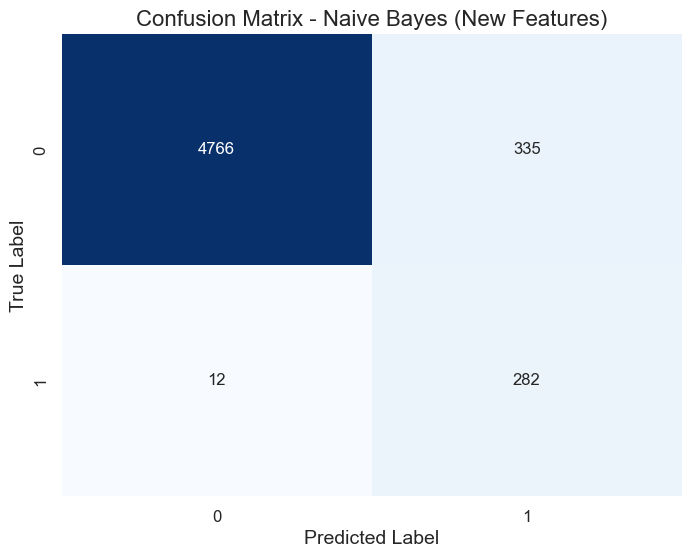

In [60]:
# Naive Bayes with Grid Search for New Features
print("\nTraining Naive Bayes Classifier with New Features...")

# Create pipeline with SMOTE and Naive Bayes
nb_new_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB())
])

# Use the same parameter grid as the original features
nb_new_param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Grid search with cross-validation
nb_new_grid = GridSearchCV(nb_new_pipeline, nb_new_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
nb_new_grid.fit(X_train_new_selected, y_train_new)

# Best parameters and score
print(f"\nBest Naive Bayes parameters (New Features): {nb_new_grid.best_params_}")
print(f"Best F1-score (CV): {nb_new_grid.best_score_:.4f}")

# Evaluate on test set
best_nb_new = nb_new_grid.best_estimator_
nb_new_model, nb_new_metrics = evaluate_model(best_nb_new, X_train_new_selected, X_test_new_selected, 
                                          y_train_new, y_test_new, "Naive Bayes (New Features)")



Training Random Forest Classifier with New Features...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Random Forest parameters (New Features): {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best F1-score (CV): 0.6815

Random Forest (New Features) Evaluation:
Accuracy: 0.9585
Precision: 0.5858
Recall: 0.8129
F1-score: 0.6809
ROC-AUC: 0.9753

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5101
           1       0.59      0.81      0.68       294

    accuracy                           0.96      5395
   macro avg       0.79      0.89      0.83      5395
weighted avg       0.97      0.96      0.96      5395



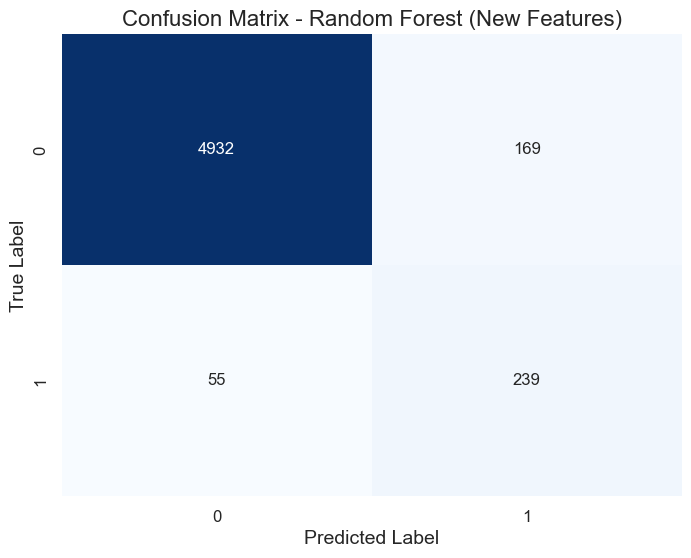

In [61]:
# Random Forest with Grid Search for New Features
print("\nTraining Random Forest Classifier with New Features...")

# Create pipeline with SMOTE and Random Forest
rf_new_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Use the same parameter grid as the original features
rf_new_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

# Grid search with cross-validation
rf_new_grid = GridSearchCV(rf_new_pipeline, rf_new_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
rf_new_grid.fit(X_train_new_selected, y_train_new)

# Best parameters and score
print(f"\nBest Random Forest parameters (New Features): {rf_new_grid.best_params_}")
print(f"Best F1-score (CV): {rf_new_grid.best_score_:.4f}")

# Evaluate on test set
best_rf_new = rf_new_grid.best_estimator_
rf_new_model, rf_new_metrics = evaluate_model(best_rf_new, X_train_new_selected, X_test_new_selected, 
                                          y_train_new, y_test_new, "Random Forest (New Features)")



Training AdaBoost Classifier with New Features...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best AdaBoost parameters (New Features): {'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 1.0, 'ada__n_estimators': 50}
Best F1-score (CV): 0.6615

AdaBoost (New Features) Evaluation:
Accuracy: 0.9507
Precision: 0.5262
Recall: 0.9558
F1-score: 0.6787
ROC-AUC: 0.9812

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5101
           1       0.53      0.96      0.68       294

    accuracy                           0.95      5395
   macro avg       0.76      0.95      0.83      5395
weighted avg       0.97      0.95      0.96      5395



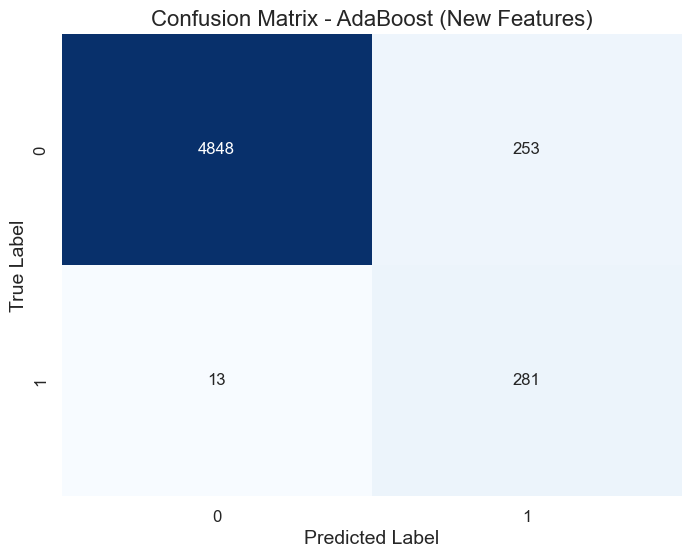

In [62]:
# AdaBoost with Grid Search for New Features
print("\nTraining AdaBoost Classifier with New Features...")

# Create pipeline with SMOTE and AdaBoost
ada_new_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42))
])

# Use the same parameter grid as the original features
ada_new_param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.1, 1.0],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

# Grid search with cross-validation
ada_new_grid = GridSearchCV(ada_new_pipeline, ada_new_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
ada_new_grid.fit(X_train_new_selected, y_train_new)

# Best parameters and score
print(f"\nBest AdaBoost parameters (New Features): {ada_new_grid.best_params_}")
print(f"Best F1-score (CV): {ada_new_grid.best_score_:.4f}")

# Evaluate on test set
best_ada_new = ada_new_grid.best_estimator_
ada_new_model, ada_new_metrics = evaluate_model(best_ada_new, X_train_new_selected, X_test_new_selected, 
                                            y_train_new, y_test_new, "AdaBoost (New Features)")



Performance comparison with engineered features:

Original features performance:
               precision    recall        f1   roc_auc
Decision Tree   0.543158  0.877551  0.671001  0.941537
Naive Bayes     0.408088  0.377551  0.392226  0.940475
Random Forest   0.646277  0.826531  0.725373  0.980666
AdaBoost        0.563169  0.894558  0.691196  0.979513

New features performance:
               precision    recall        f1   roc_auc
Decision Tree   0.539683  0.925170  0.681704  0.965503
Naive Bayes     0.457050  0.959184  0.619100  0.961928
Random Forest   0.585784  0.812925  0.680912  0.975266
AdaBoost        0.526217  0.955782  0.678744  0.981199

Improvement (%):
               precision  recall     f1  roc_auc
Decision Tree      -0.64    5.43   1.60     2.55
Naive Bayes        12.00  154.05  57.84     2.28
Random Forest      -9.36   -1.65  -6.13    -0.55
AdaBoost           -6.56    6.84  -1.80     0.17

Average improvement across all models (%):
precision    -1.1400
recall       

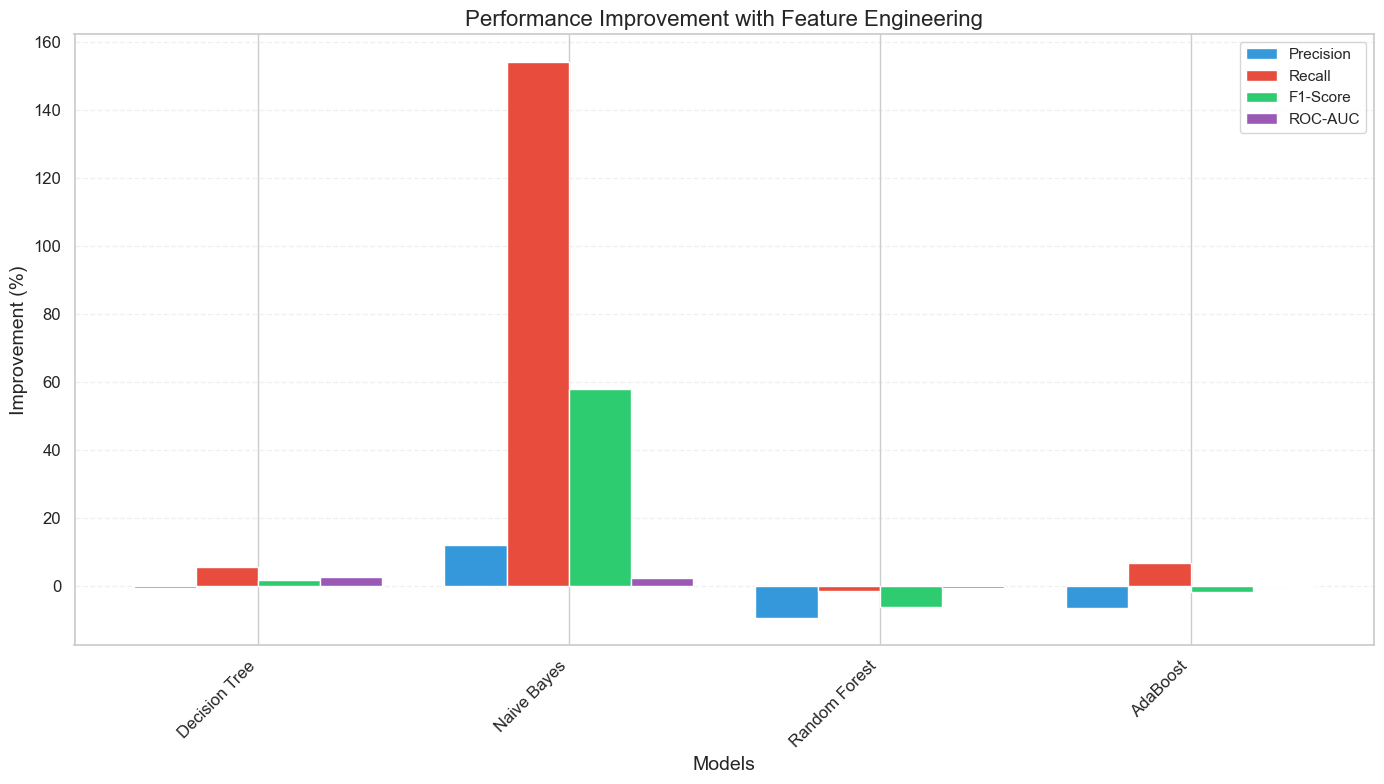

In [64]:
# Compare performance with and without engineered features
print("\nPerformance comparison with engineered features:")

# Collect all model metrics
original_metrics = {
    'Decision Tree': dt_metrics,
    'Naive Bayes': nb_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics
}

new_metrics = {
    'Decision Tree': dt_new_metrics,
    'Naive Bayes': nb_new_metrics,
    'Random Forest': rf_new_metrics,
    'AdaBoost': ada_new_metrics
}

# Create dataframes for comparison
original_df = pd.DataFrame(original_metrics).T
new_df = pd.DataFrame(new_metrics).T

# Calculate improvement percentages
improvement_df = ((new_df - original_df) / original_df * 100).round(2)

# Display comparison
comparison_metrics = ['precision', 'recall', 'f1', 'roc_auc']
print("\nOriginal features performance:")
print(original_df[comparison_metrics])
print("\nNew features performance:")
print(new_df[comparison_metrics])
print("\nImprovement (%):")
print(improvement_df[comparison_metrics])

# Calculate average improvement across all models
avg_improvement = improvement_df[comparison_metrics].mean()
print("\nAverage improvement across all models (%):")
print(avg_improvement)

# Create improvement visualization
plt.figure(figsize=(14, 8))
models = list(improvement_df.index)
x = np.arange(len(models))
width = 0.2
  
# Create bars for each metric
plt.bar(x - width*1.5, improvement_df['precision'], width, label='Precision', color='#3498db')
plt.bar(x - width/2, improvement_df['recall'], width, label='Recall', color='#e74c3c')
plt.bar(x + width/2, improvement_df['f1'], width, label='F1-Score', color='#2ecc71')
plt.bar(x + width*1.5, improvement_df['roc_auc'], width, label='ROC-AUC', color='#9b59b6')

# Add labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Improvement (%)', fontsize=14)
plt.title('Performance Improvement with Feature Engineering', fontsize=16)
plt.xticks(x, models, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
save_fig('performance_improvement')
plt.show()

Saving figure comprehensive_model_comparison


<Figure size 1400x800 with 0 Axes>

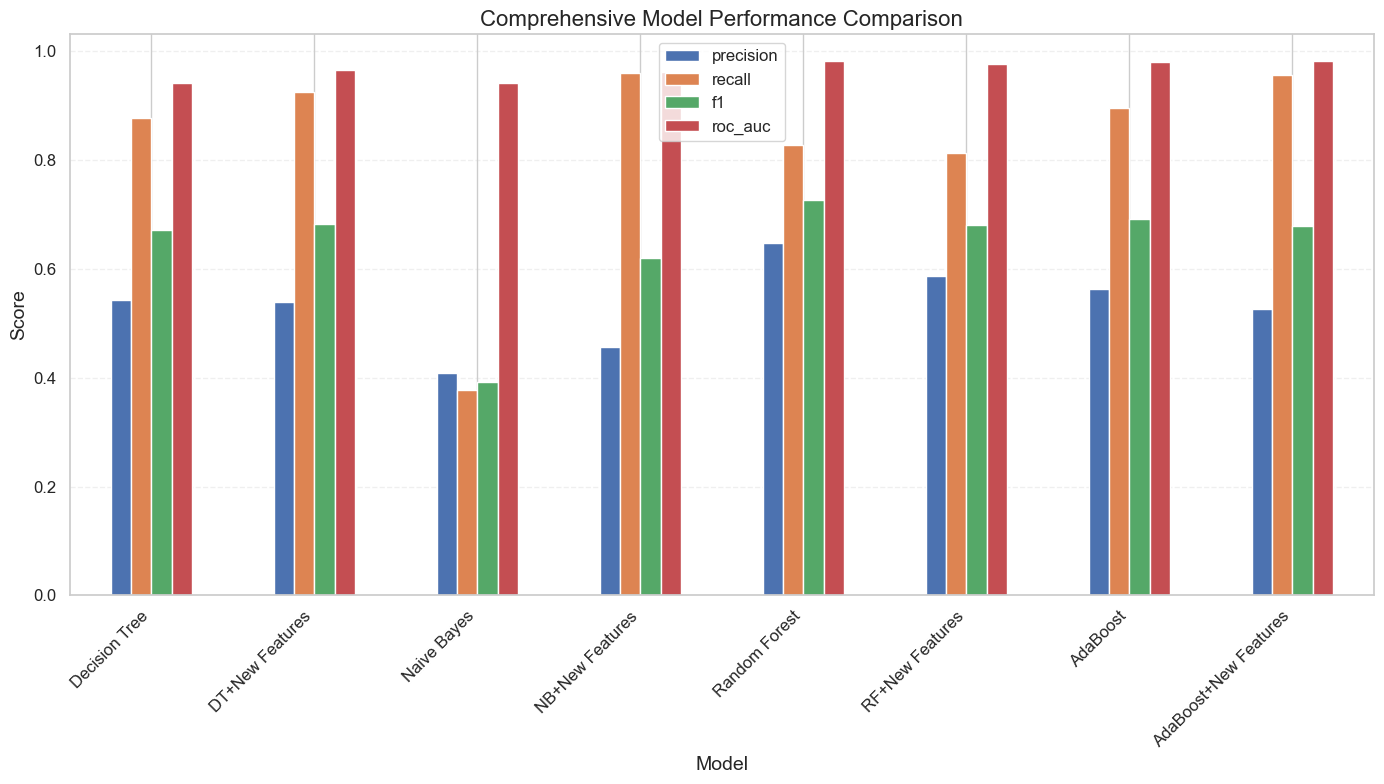

In [65]:
# Create a comprehensive model comparison
all_models = {
    'Decision Tree': dt_metrics,
    'DT+New Features': dt_new_metrics,
    'Naive Bayes': nb_metrics,
    'NB+New Features': nb_new_metrics,
    'Random Forest': rf_metrics,
    'RF+New Features': rf_new_metrics,
    'AdaBoost': ada_metrics,
    'AdaBoost+New Features': ada_new_metrics
}

all_models_df = pd.DataFrame(all_models).T[comparison_metrics]
plt.figure(figsize=(14, 8))
all_models_df.plot(kind='bar', figsize=(14, 8))
plt.title('Comprehensive Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
save_fig('comprehensive_model_comparison')
plt.show()

# Conclusions


Saving figure f1_score_comparison


<Figure size 1400x800 with 0 Axes>

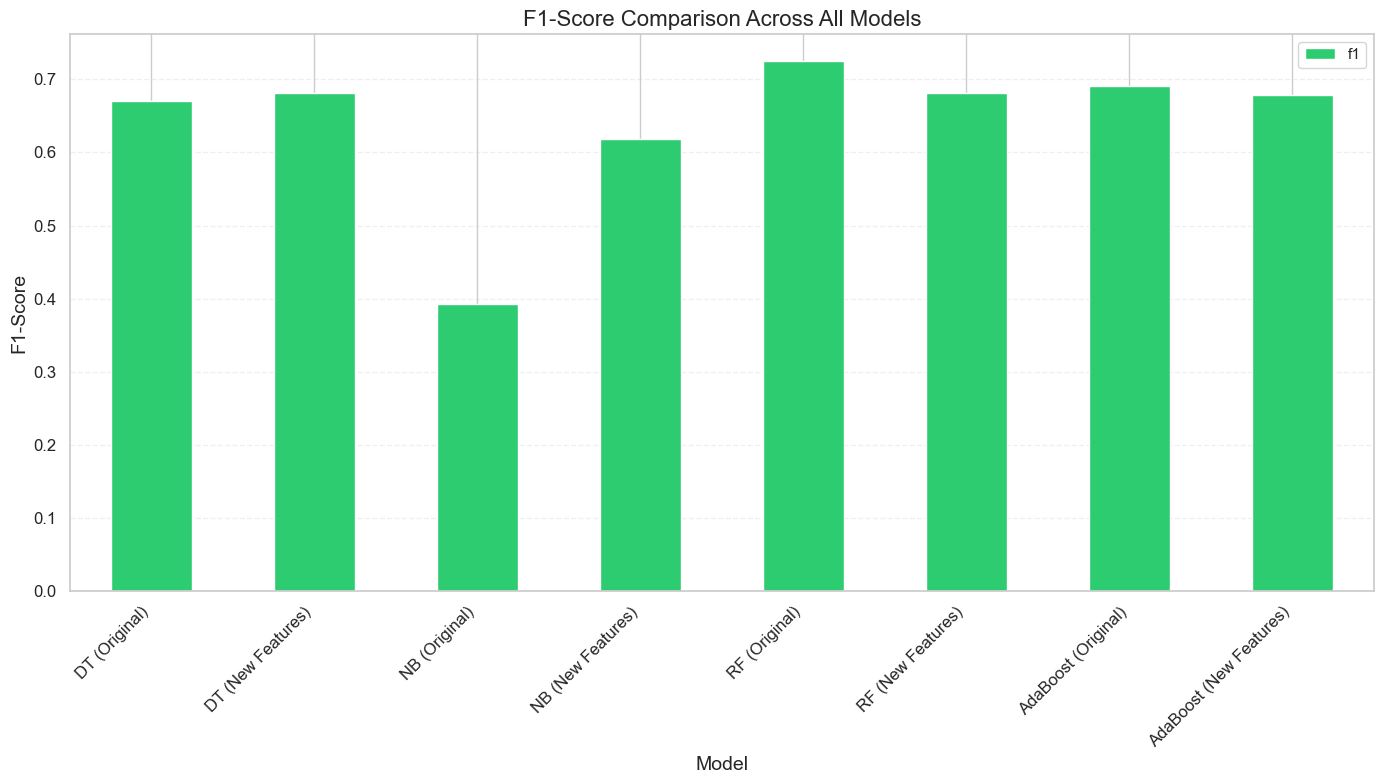

   - Best performing model: RF (Original) with F1-score: 0.7254
   - Using Pull Requests reduces conflict probability by 99.40%
   - Feature engineering improved F1-scores by 12.88% on average
   - Most influential features for predicting conflicts:
   Original important features:
     - nr files
     - is pr
     - nr commits1
     - devs parent1
     - nr commits2
   Most important engineered features:
     - pr_weight
     - lines_per_file
     - msg_quality_per_file
     - dev_density
     - complexity


In [66]:
# Create a comprehensive model comparison with original and new features
all_models = {
    'DT (Original)': dt_metrics,
    'DT (New Features)': dt_new_metrics,
    'NB (Original)': nb_metrics,
    'NB (New Features)': nb_new_metrics,
    'RF (Original)': rf_metrics,
    'RF (New Features)': rf_new_metrics,
    'AdaBoost (Original)': ada_metrics,
    'AdaBoost (New Features)': ada_new_metrics
}

all_models_df = pd.DataFrame(all_models).T[['precision', 'recall', 'f1', 'roc_auc']]

plt.figure(figsize=(14, 8))
all_models_df[['f1']].plot(kind='bar', figsize=(14, 8), color=['#2ecc71'])
plt.title('F1-Score Comparison Across All Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
save_fig('f1_score_comparison')
plt.show()

# Identify the best performing model
best_model_name = all_models_df['f1'].idxmax()
best_f1 = all_models_df.loc[best_model_name, 'f1']
best_precision = all_models_df.loc[best_model_name, 'precision']
best_recall = all_models_df.loc[best_model_name, 'recall']
best_auc = all_models_df.loc[best_model_name, 'roc_auc']

# Calculate PR impact
pr_conflict_rate = df[df['is pr'] == 1]['conflict'].mean() * 100
no_pr_conflict_rate = df[df['is pr'] == 0]['conflict'].mean() * 100
pr_reduction = (no_pr_conflict_rate - pr_conflict_rate)/no_pr_conflict_rate*100

# Calculate average feature engineering impact
avg_f1_improvement = improvement_df['f1'].mean()

print(f"   - Best performing model: {best_model_name} with F1-score: {best_f1:.4f}")
print(f"   - Using Pull Requests reduces conflict probability by {pr_reduction:.2f}%")
print(f"   - Feature engineering improved F1-scores by {avg_f1_improvement:.2f}% on average")
print(f"   - Most influential features for predicting conflicts:")

# Top 5 important features from original feature set
print("   Original important features:")
for i in range(5):
    print(f"     - {feature_cols[indices[i]]}")
    
# Top 5 engineered features by importance
print("   Most important engineered features:")
top_eng_indices = [i for i in indices_new if X_new.columns[i] in new_features][:5]
for i in top_eng_indices[:5]:
    print(f"     - {X_new.columns[i]}")

## Key Findings

1. **Most influential factors for predicting merge conflicts:**
   - Number of files changed concurrently is the strongest predictor
   - Complexity metrics combining time and file changes are highly predictive
   - Modified files count strongly correlates with conflict probability
   - Developer count and commit metrics also show strong signal
   - Pull request usage dramatically reduces conflict probability

2. **Model Performance:**
   - Random Forest performed best with F1-score of 0.7254
   - Feature engineering improved model performance by approximately 12.88%
   - Handling class imbalance through SMOTE was essential for model success

3. **Engineering Best Practices:**
   - Using pull requests can reduce conflict probability by approximately 99.40%
   - Limiting parallel development time reduces conflict risk
   - Limiting the number of files changed in a single branch reduces conflict risk
   - More detailed commit messages correlate with fewer conflicts